In [33]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt 
import textwrap

In [34]:
def customer_identifier(df): 
    '''
        It handles strings in the "Customer" column of the Products DataFrame.
        "Customer" values are strings with '-' character splitting customer names from countries and/or 
        another specifications such as competitor product/brand/company. 
        This method splits the string, maintaining at the Customer column only the actual customer name.
        The remaining info is reallocated to the new columns "Specifics" and "Competitor".
        It only applies to product DataFrame in this specific context!

        Arguments:
            df: DataFrame (product DataFrame)

        Returns:
            df_result: DataFrame (resulting DataFrame after string handling)
    '''

    df_result = df
    df_result["Competitor"] = 0
    df_result["Specifics"] = df_result["Customer"]
    df_result["Specifics"] = df_result["Specifics"].str.replace(r'^.+ - ','')
    df_result["Customer"] = df_result["Customer"].str.replace(r' - .+$','')

    # All character uppercased 
    df_result[(df_result["Customer"].str.isupper())&((df_result["Customer"].str.find(r'[A-Z]+'))>3)]["Customer"].str.title()

    df_result.loc[(df_result["Specifics"].str.find("Concorrente")!=-1),"Competitor"] = 1
    df_result.loc[(df_result["Specifics"].str.find("Concorrente")!=-1),"Specifics"].str.replace("Concorrente",'')
    
    return df_result


def verify_inconsistences(df):
    '''
        It verifies some inconsistences in the DataFrame, such as the following situations:

        1. Uncompatible 'Availabe'-'Unavailable' values
        2. 'RandomPrecosNegativos' indicating positive final price while 
            'FinalPrice' value is actually negative
        3. 'RandomPrecosMissing' indicating missing final price while 'FinalPrice'
            value is not missing, or 'RandomPrecosMissing' indicating no missing value
            while 'FinalPrice' value is actually missing

        Arguments:
            df: DataFrame ('coletas' DataFrame)

        Returns:
            None
    '''

    # Situation 1
    assert df[(df["Available"]==df["Unavailable"])].empty,\
    "Inconsistencies with 'Available 'Unavailable' values!"
    
    # Situation 2
    assert df[(df["RandomPrecosNegativos"]==1)&(df["FinalPrice"]<0)].empty,\
    "Inconsistencies with negative final price values!"

    # Situation 3
    assert df.loc[
    ((df["RandomPrecosMissing"] == 0)&(df["FinalPrice"] != 0))|
    ((df["RandomPrecosMissing"] == 1)&(df["FinalPrice"] == 0)),"FinalPrice"
    ].empty, "Inconsistencies with values ​​missing from final prices!"
    
    return None


def fix_inconsistences(df, key_error):
    '''
        It fixes some inconsistences in the DataFrame, indicated by the 'key_error' string.

        1. 'missing':  If the Final Price is missing, we get Suggested Price instead
        2. 'negative': If the Final Price is negative, we get the mean of same EAN 
            positive Final Prices instead

        Arguments:
            df_coleta: DataFrame ('coletas' DataFrame)
            key_error: str (string indicating which type of inconsistence we're dealing with)

        Returns:
            df_coleta: DataFrame ('coletas' DataFrame with modifications)
    '''

    df_result = df
    # Situation 1
    if (key_error == 'missing'):
        df_result.loc[((df_result["RandomPrecosMissing"] == 0)|(df_result["FinalPrice"] == 0)),"FinalPrice" ] = \
        df_result.loc[((df_result["RandomPrecosMissing"] == 0)|(df_result["FinalPrice"]==0)),"SuggestedPrice"]
        df_result.loc[((df_result["RandomPrecosMissing"] == 0)|(df_result["FinalPrice"] == 0)),"RandomPrecosMissing"] = 1

    # Situation 2
    elif(key_error == 'negative'):
        mean_prices = pd.DataFrame(df_result.loc[(df["FinalPrice"] > 0),
        ["FinalPrice","MasterKey_RetailerProduct"]].groupby("MasterKey_RetailerProduct").mean())


        for item in df_result.loc[(df_result["FinalPrice"] < 0),["FinalPrice","MasterKey_RetailerProduct"]].index.values:
            df_result.loc[item,"FinalPrice"] = mean_prices.loc[str(df_result.loc[item,"MasterKey_RetailerProduct"])]["FinalPrice"]
            df_result.loc[item,"RandomPrecosNegativos"] = 1
    return df_result

In [43]:
# Folder path
path =  "../data/"

# Which values are considered NaN
na_vls = ['#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', 
               '1.#IND', '1.#QNAN', '<NA>', 'N/A', 'NA', 'NULL', 'NaN', 'n/a', 'nan', 
                'null', '...']

nrows = 200000

# Load datasets
df_prod = pd.read_csv(path+"ProdutosVarejos.csv", na_values = na_vls, nrows = nrows)
df_coletas = pd.read_csv(path+"Coletas.csv", na_values = na_vls, nrows = nrows)

# Handling missing values
df_coletas.dropna(inplace=True, how = 'all')
df_prod.dropna(inplace=True, how = 'all')
df_prod.fillna(value = '', inplace=True)
df_coletas.fillna(value = 0, inplace=True)

# Register DataFrames Shapes
clt_cols, clt_rows = df_coletas.shape
prd_cols, prod_rows = df_prod.shape

# Types for each DataFrame column
prod_types = {'Customer': 'str',
                'Department': 'str',
                'Category': 'str',
                'Brand': 'str',
                'EAN': 'str',
                'Product': 'str',
                'Retailer': 'str',
                'MasterKey_RetailerProduct': 'str'}

coletas_types = {'DateIns': 'str', 
                    'Screenshot': 'str', 
                    'Available': 'int64', 
                    'Unavailable': 'int64', 
                    'SuggestedPrice' : 'float64',
                    'FinalPrice': 'float64', 
                    'MasterKey_RetailerProduct': 'str', 
                    'RandomPrecosNegativos': 'int64',
                    'RandomPrecosMissing': 'int64', 
                    'RandomPrecosDiscrepantes': 'int64',
                    'RandomPrecosDiscrepantesFator': 'float64'}

# Casting DataFrames columns according to the types above
df_prod = df_prod.astype(prod_types)
df_coletas= df_coletas.astype(coletas_types)

# Adjusting strings in "Customer" column
df_prod = customer_identifier(df_prod)

# Transforming 'DateIns' column in a Pandas datetype time series
df_coletas["DateIns"] = pd.to_datetime(df_coletas["DateIns"].values).strftime('%d-%m')

# Formatting "Department","Category", "Product" columns strings to begin (each word) with upper case 

for cols in df_prod[["Department","Category"]].columns.values:
    df_prod[cols] = df_prod[cols].str.capitalize()

# Formatting "Brand" column value strings to begin with upper case  
# All character uppercased 
df_prod[(df_prod["Brand"].str.isupper())&((df_prod["Customer"].str.find(r'[A-Z]+'))>3)]["Brand"].str.title()


C:\Users\luiza\AppData\Local\Temp\ipykernel_14860\3306551824.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  df_result["Specifics"] = df_result["Specifics"].str.replace(r'^.+ - ','')
C:\Users\luiza\AppData\Local\Temp\ipykernel_14860\3306551824.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  df_result["Customer"] = df_result["Customer"].str.replace(r' - .+$','')


Series([], Name: Brand, dtype: object)

In [44]:
# Inconsistences fixing and verification
df_coletas = fix_inconsistences(df_coletas, 'missing')
df_coletas = fix_inconsistences(df_coletas, 'negative')

In [37]:
# Saving Clean Data
df_coletas.to_csv(path_or_buf=path+"New_Coletas.csv",  columns=df_coletas.columns.values)
df_prod.to_csv(path_or_buf=path+"New_ProdutosVarejos.csv",  columns=df_prod.columns.values)

C:\Users\luiza\AppData\Local\Temp\ipykernel_14860\2807706935.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ).mean()[["SuggestedPrice","FinalPrice"]]


Retailer                                        Amazon
Product                                               
Lava Roupas Líquido Brilhante Limpeza Total 3L   45.14


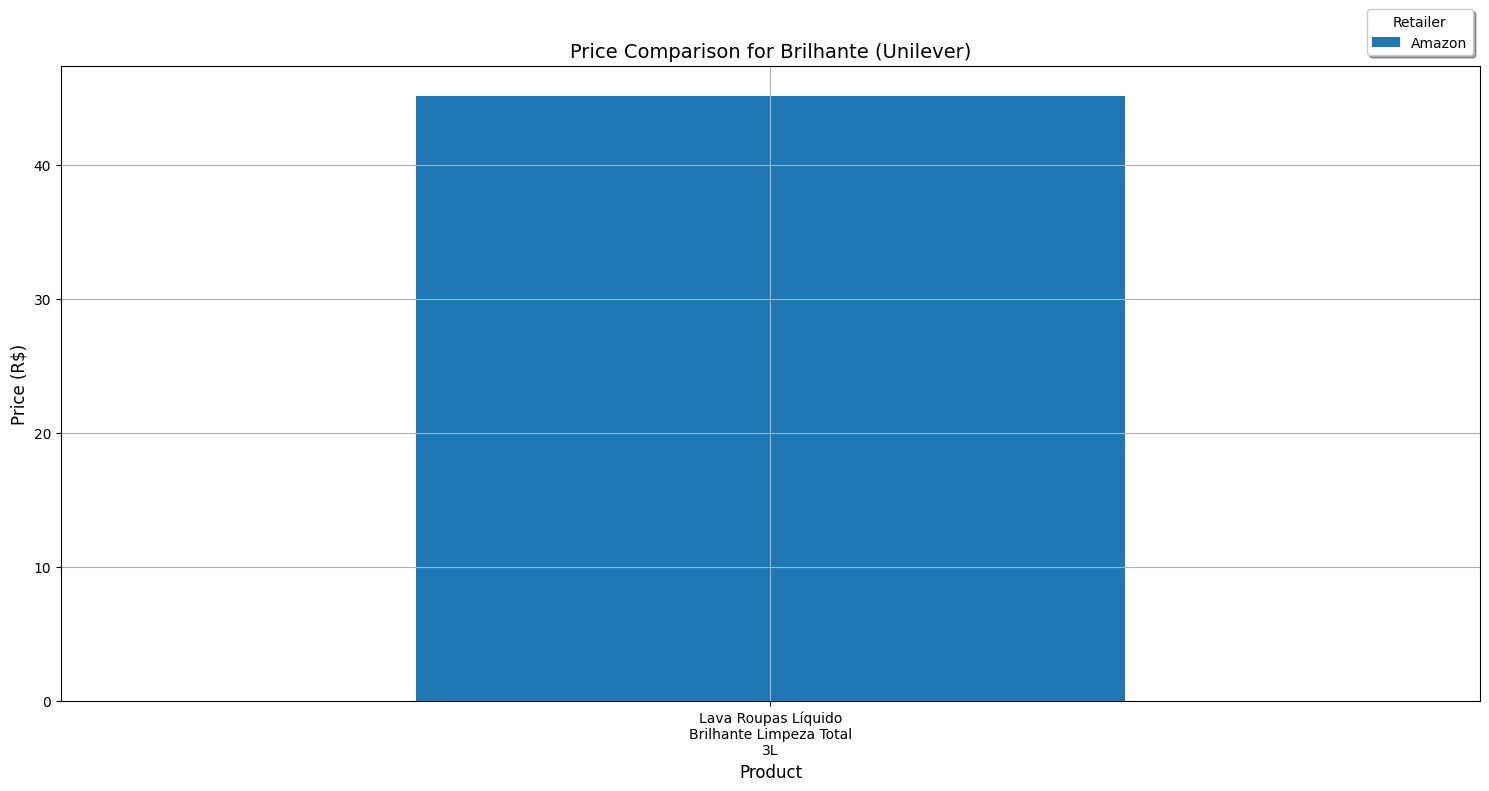

Retailer                               Amazon  DrogaRaia
Product                                                 
Creme Dental Closeup Triple Menta 70g    2.68       7.09


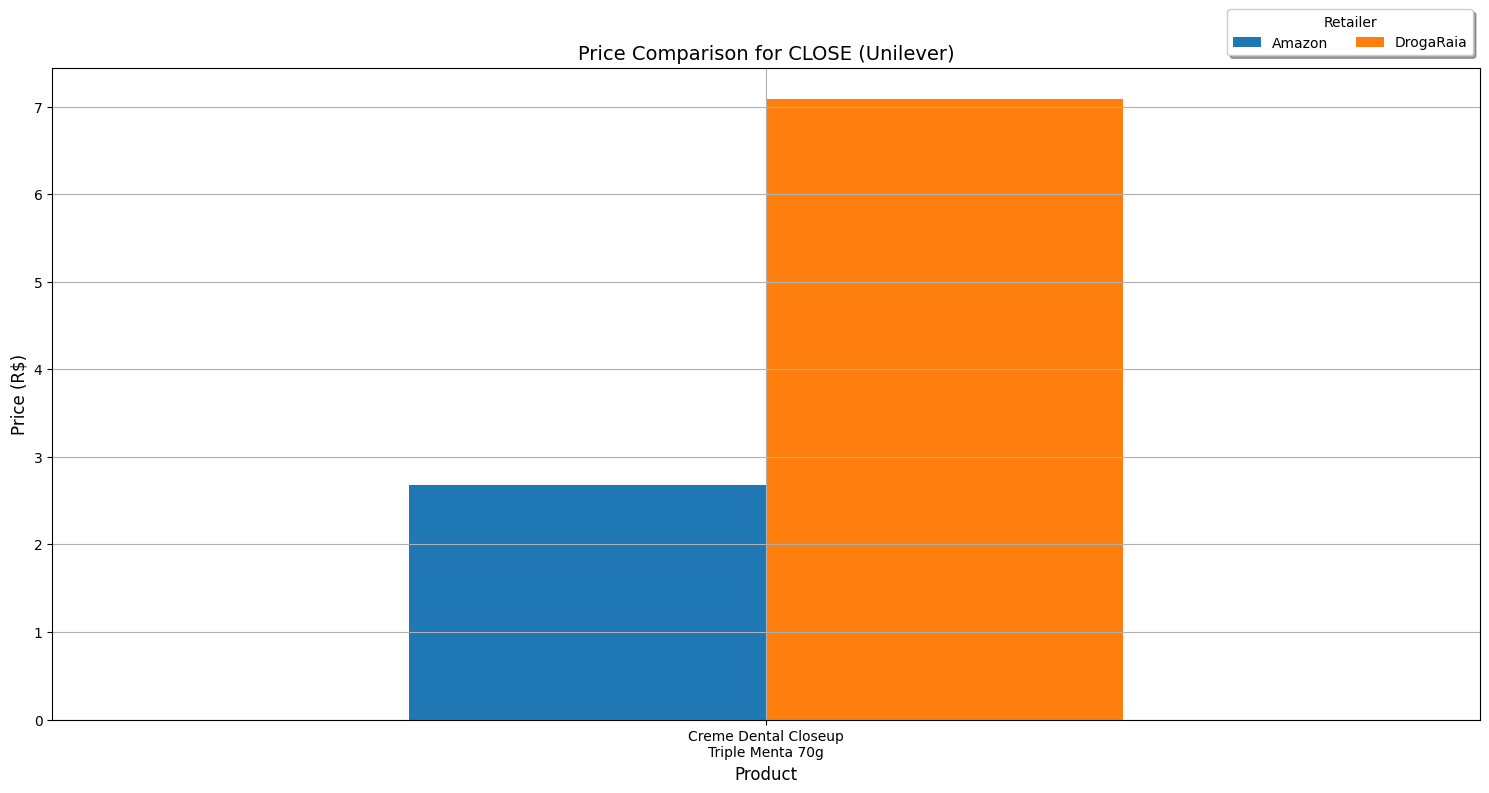

Retailer                                            Amazon  DrogaRaia  \
Product                                                                 
Shampoo Anticaspa Clear Men Limpeza Diária 2 em...   41.44      49.13   
Shampoo Anticaspa Clear Sports Men Limpeza Prof...   39.26      50.15   

Retailer                                            Mercado Livre  
Product                                                            
Shampoo Anticaspa Clear Men Limpeza Diária 2 em...          39.03  
Shampoo Anticaspa Clear Sports Men Limpeza Prof...          39.93  


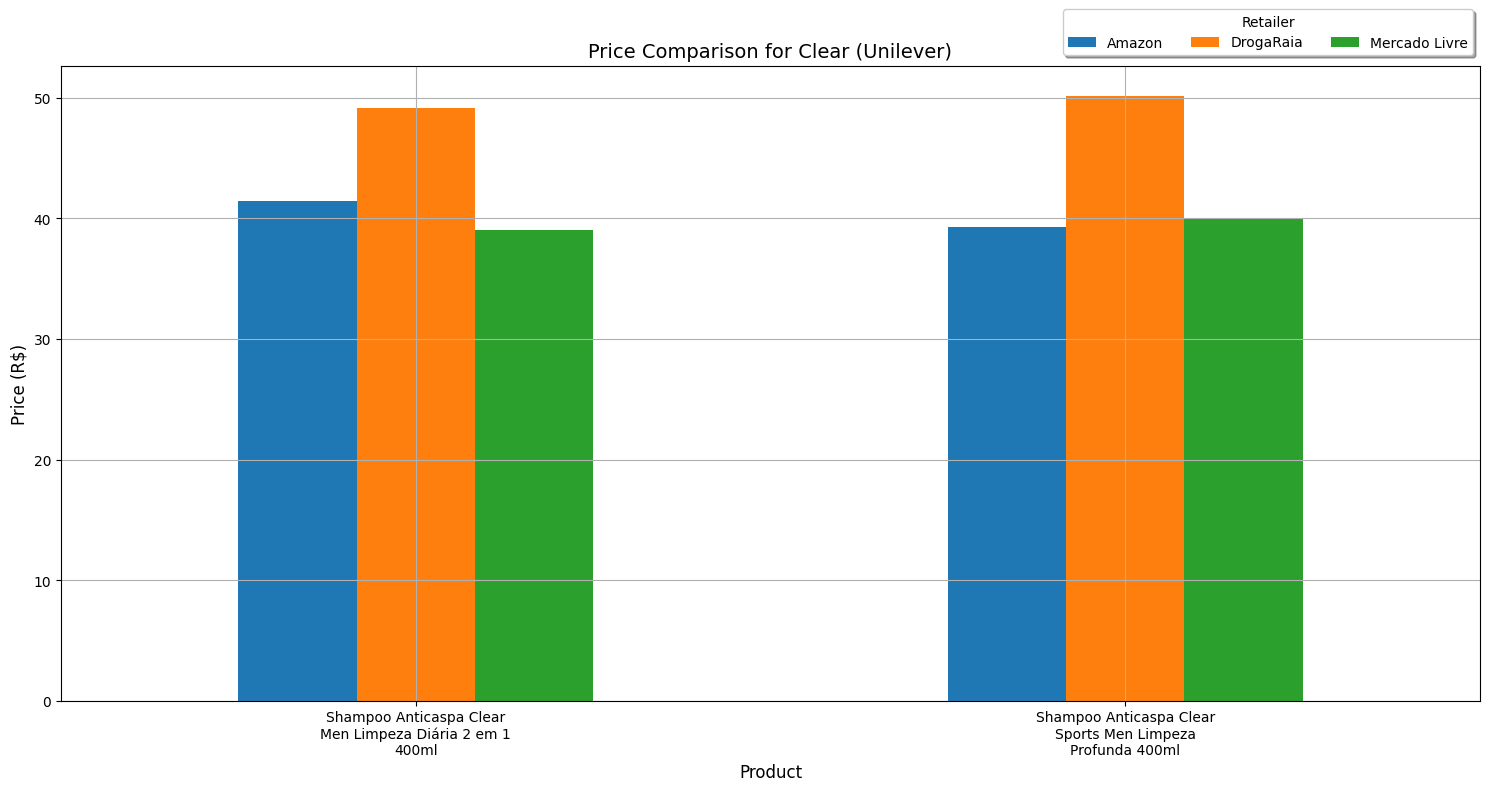

Retailer                                 Amazon  DrogaRaia
Product                                                   
Gel Dental Close Up Liquifresh Ice 100g    9.45        8.1


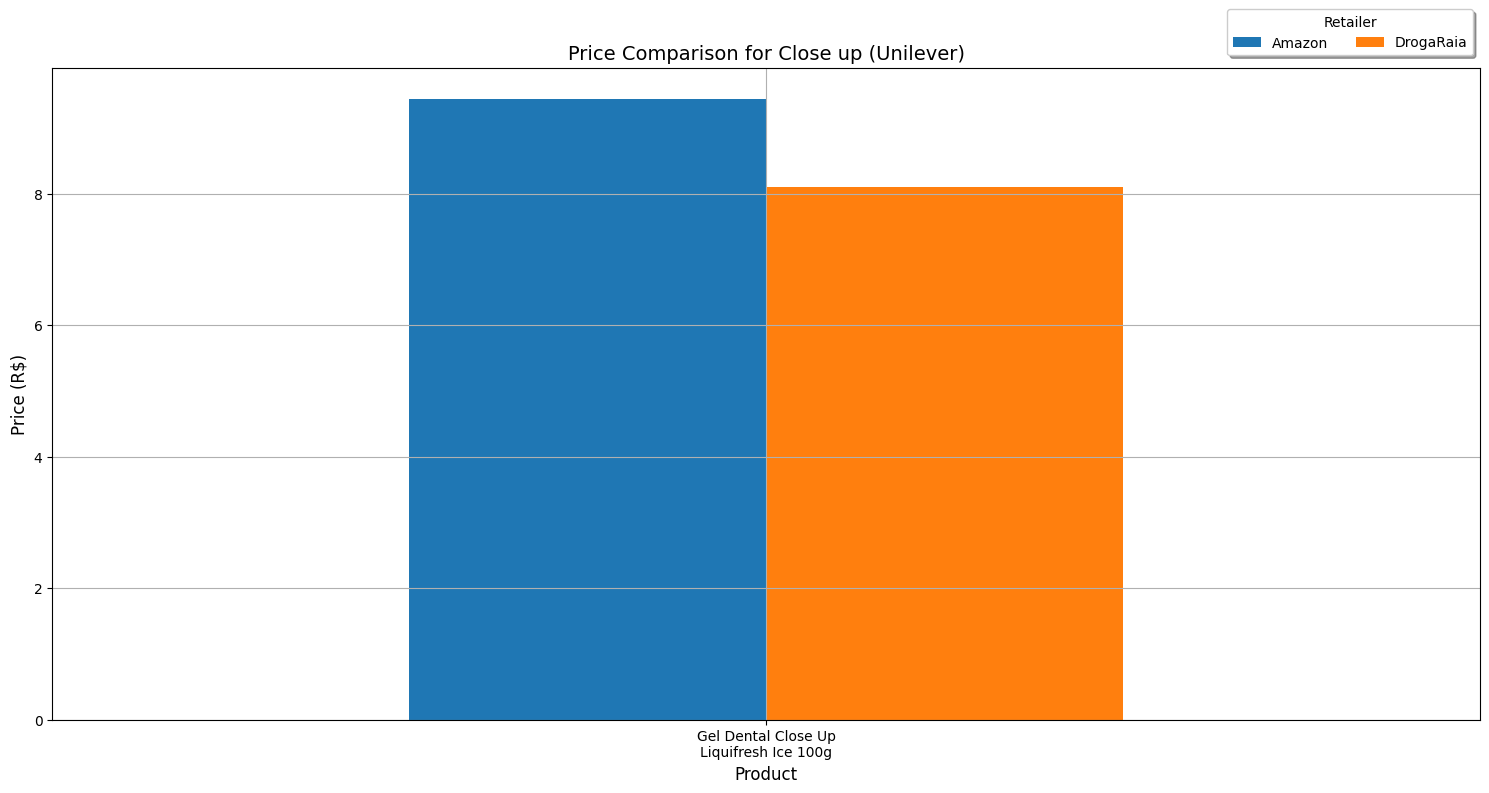

Retailer                                            Amazon
Product                                                   
Amaciante Comfort Pro Lavanderia Profissional 10L    74.51
Amaciante Concentrado  Comfort Brisa Elegante 1 L    36.34
Amaciante Concentrado Comfort Frescor Intenso 5...   21.68
Amaciante Concentrado Comfort Puro Cuidado 1 L       37.05


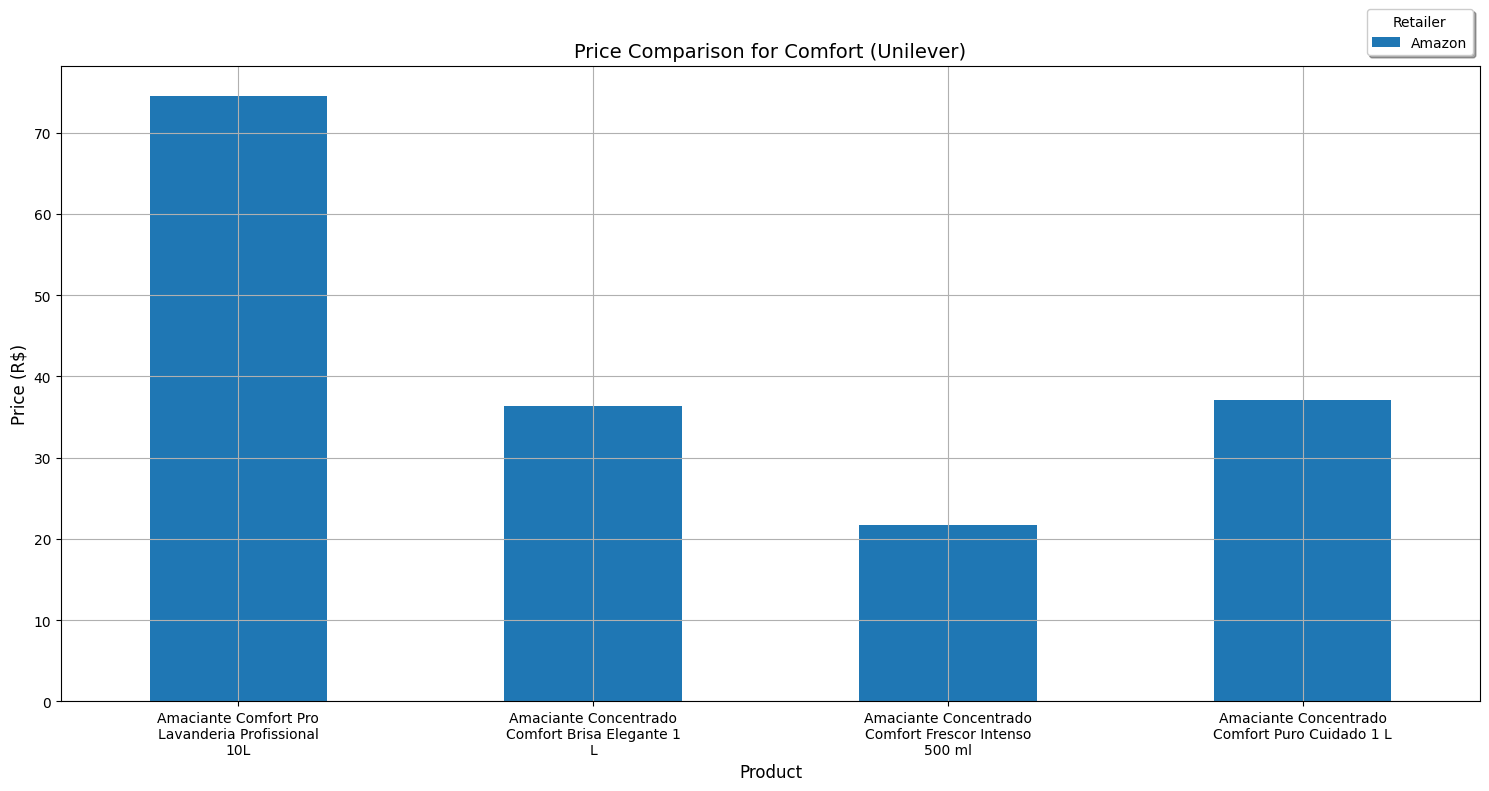

Retailer                                            Amazon  DrogaRaia
Product                                                              
Condicionador de Glicerina Baby Dove Hidratação...   14.45      35.53
Refil Sabonete Líquido Baby Dove Hidratação Enr...   16.22      21.26
Sabonete Líquido Baby Dove Hidratação Glicerina...   23.53      25.36
Shampoo Baby Dove Hidratação Enriquecida 400ml       21.66      33.47
Shampoo de Glicerina Baby Dove Hidratação Glice...   19.01      19.78


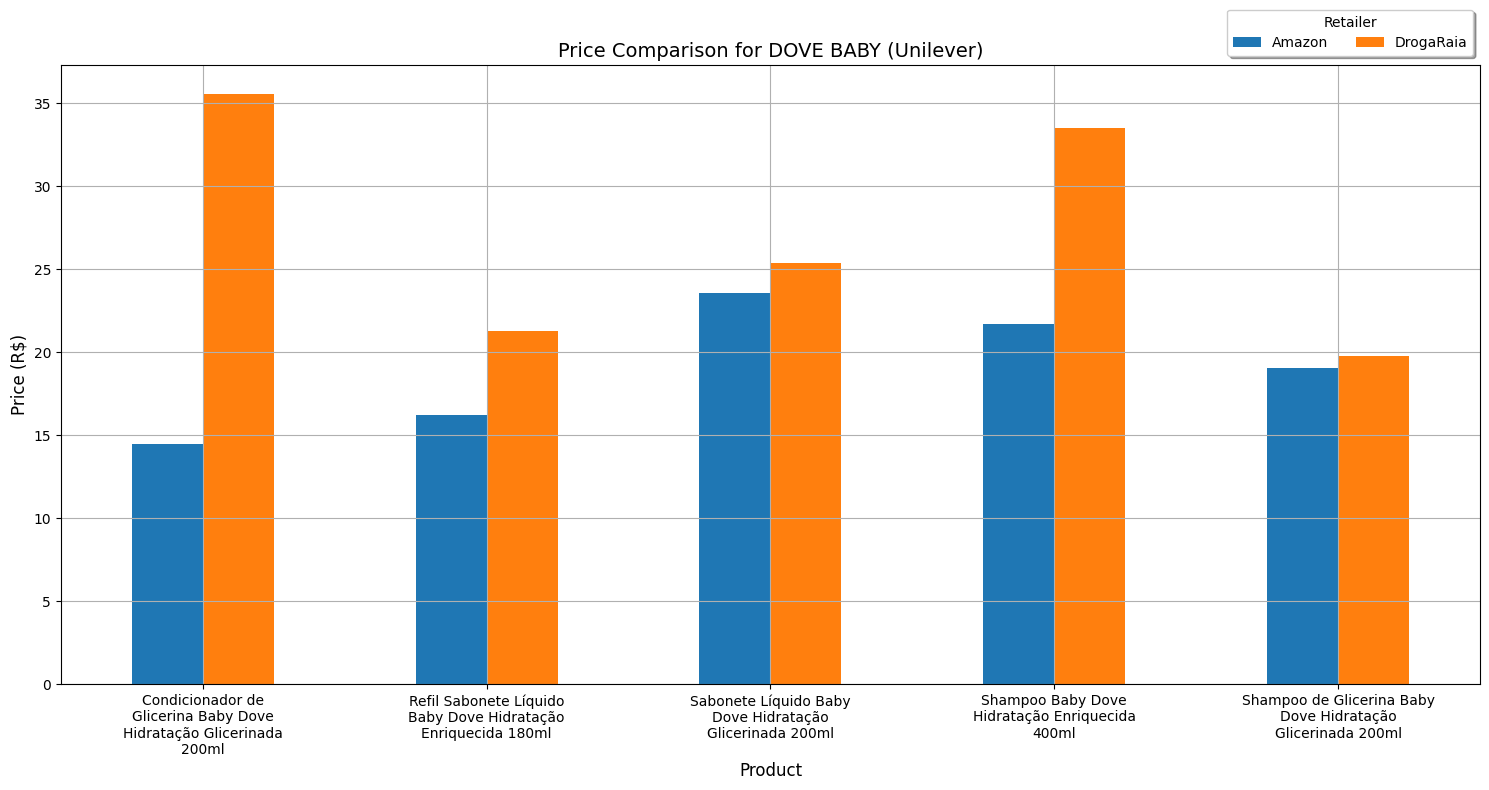

Retailer                                        Amazon  DrogaRaia  \
Product                                                             
Sabonete em Barra Dove Original 90g 6 unidades   43.81      27.36   

Retailer                                        Mercado Livre  
Product                                                        
Sabonete em Barra Dove Original 90g 6 unidades          43.62  


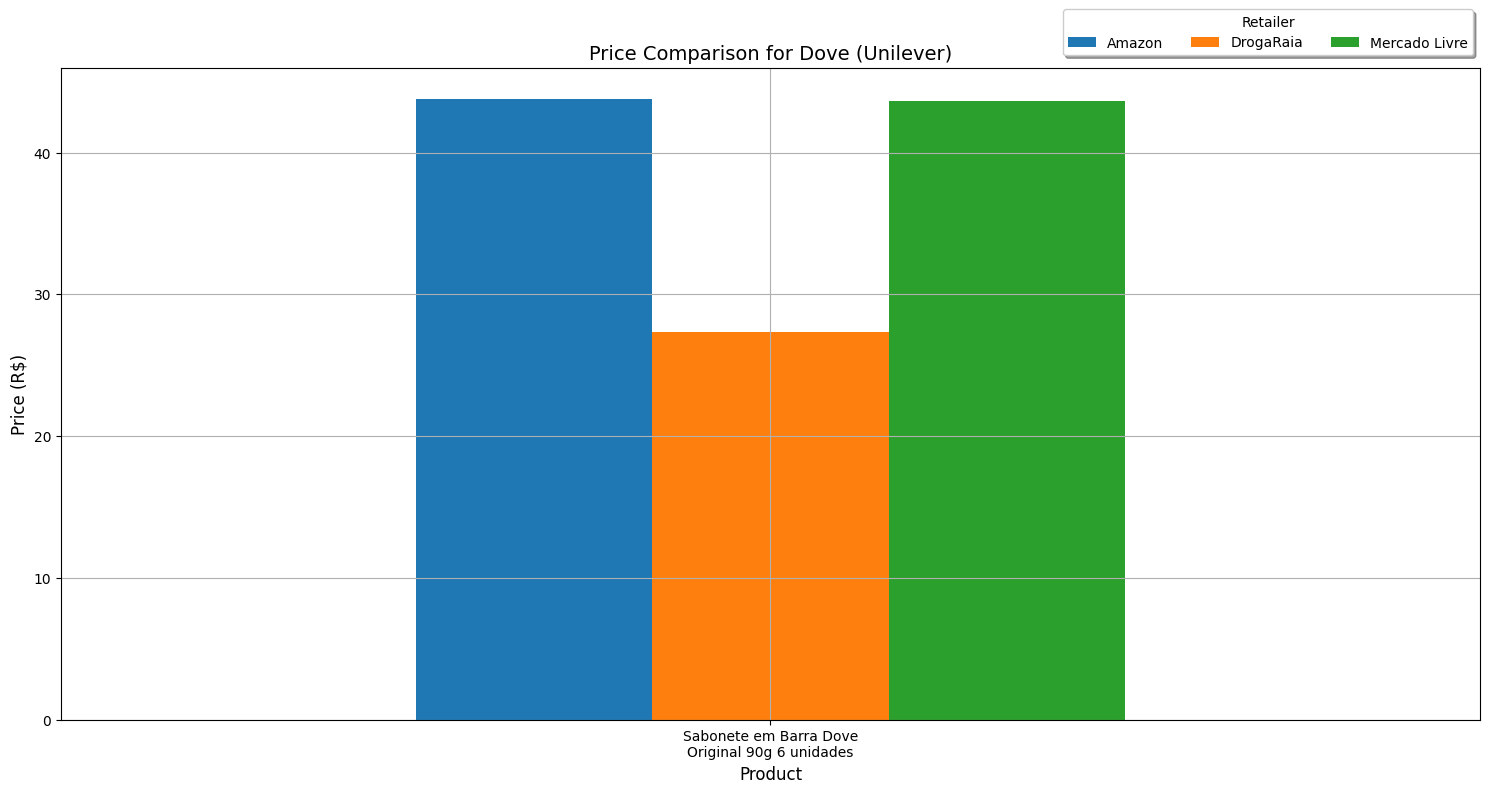

Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Retailer                                            Amazon  DrogaRaia
Product                                                              
Condicionador Love Beauty And Planet Energizing...   33.45      51.30
Shampoo Love Beauty And Planet Energizing Detox...   27.39      50.11


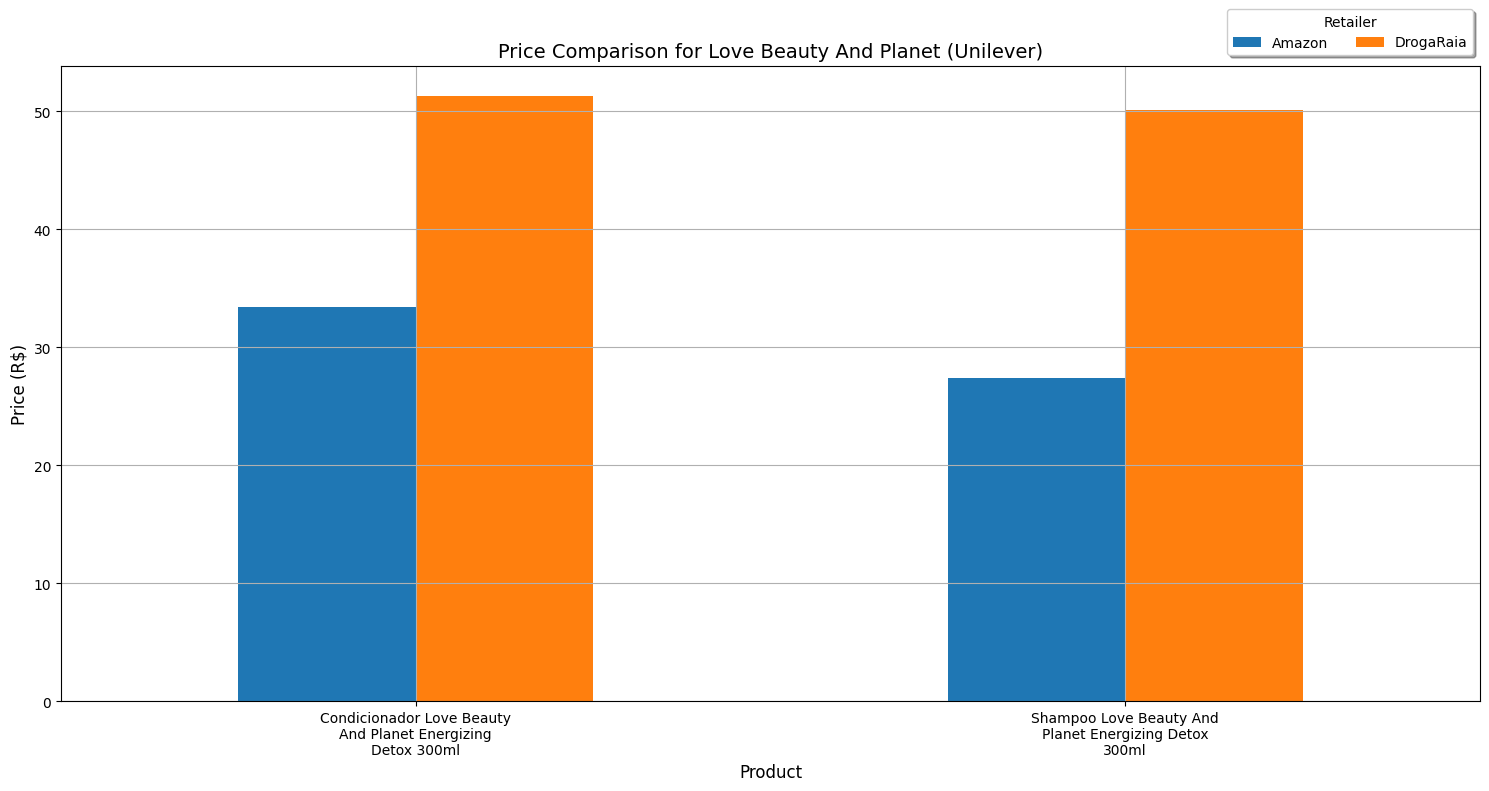

Retailer                                            Amazon  DrogaRaia
Product                                                              
Sabonete em barra Lux Buque de Jasmim 85g 4 uni...    4.39      10.07


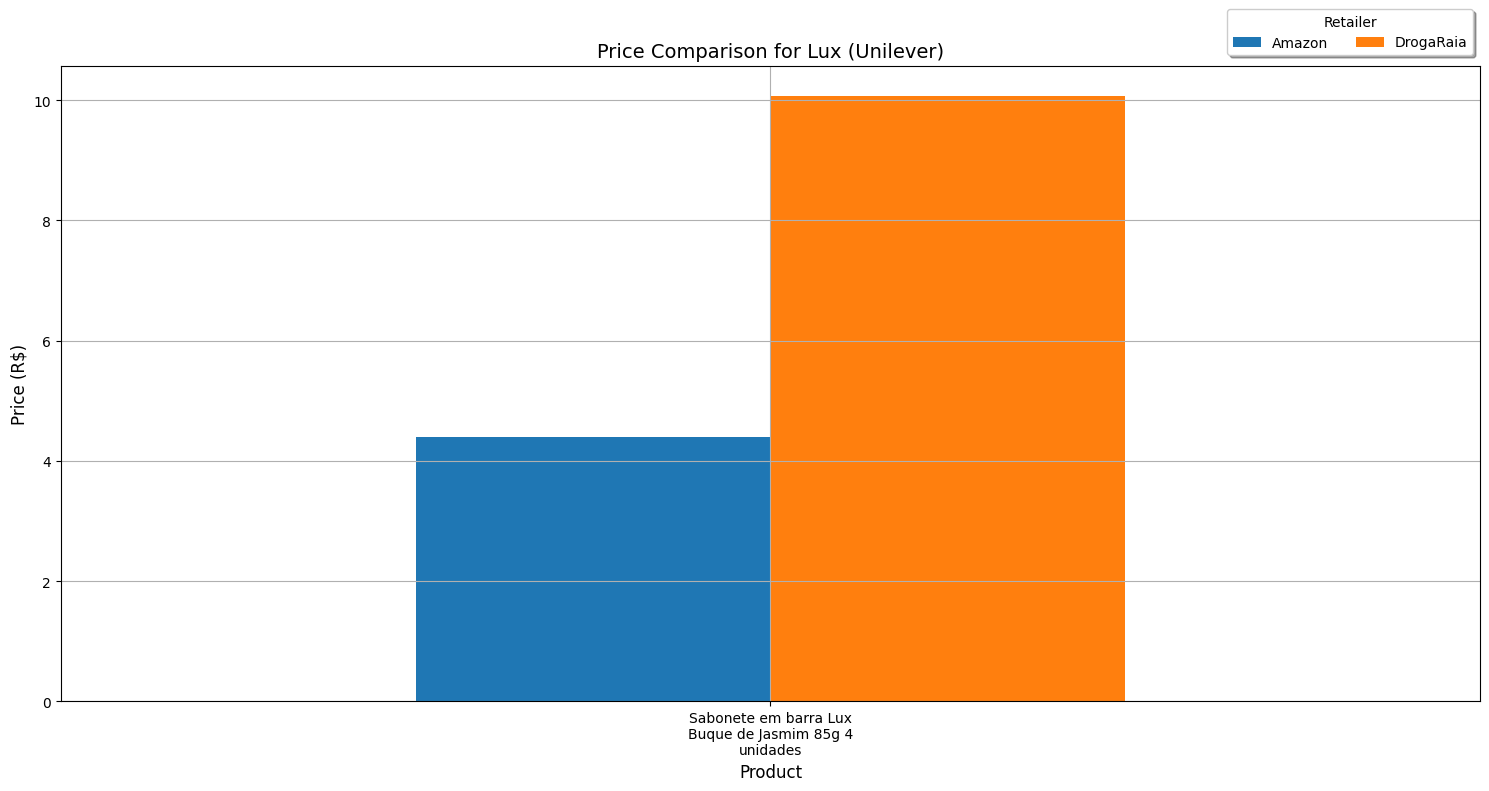

Empty DataFrame
Columns: []
Index: []
Retailer                                  DrogaRaia
Product                                            
Snack Saudável Mãe Terra Remix Cacau 25g       8.32


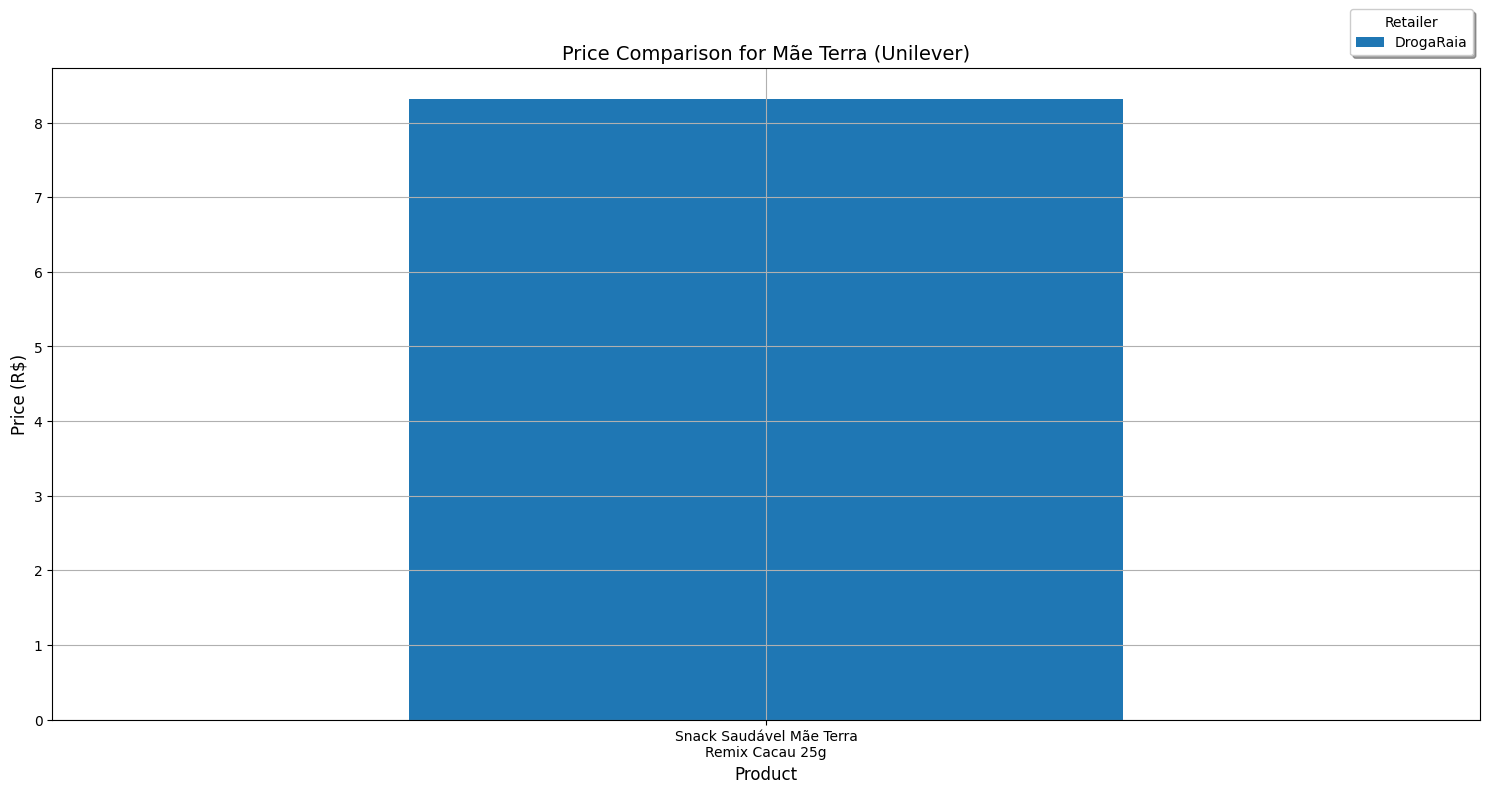

Retailer                                            DrogaRaia
Product                                                      
Condicionador Nexxus Keraphix Queratina e Arroz...      53.38
Shampoo Nexxus Keraphix Queratina e Arroz Negro...      57.40


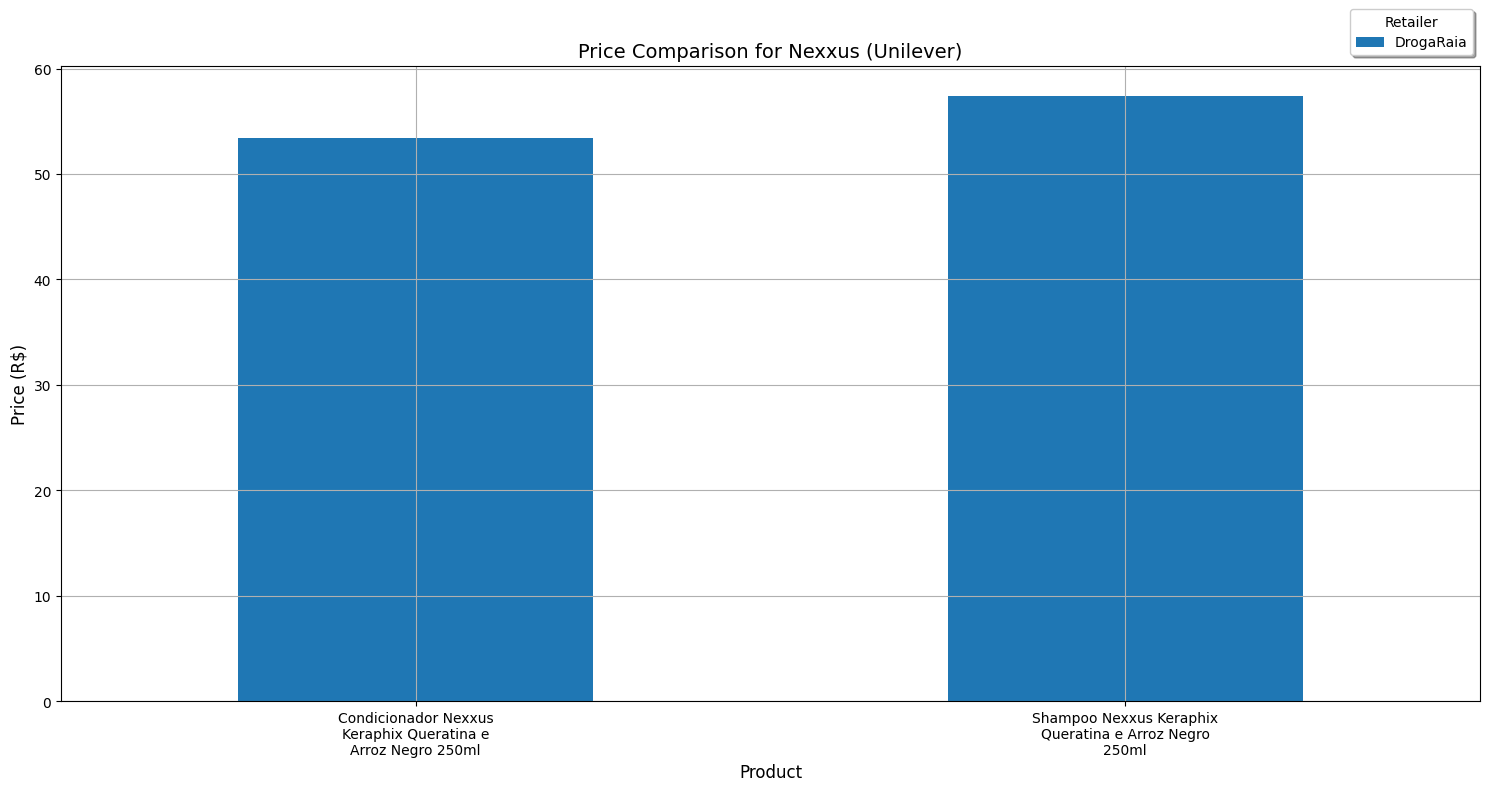

Retailer                               Amazon  Mercado Livre
Product                                                     
Sabão Líquido Omo Lavagem Perfeita 5L   63.86          75.36


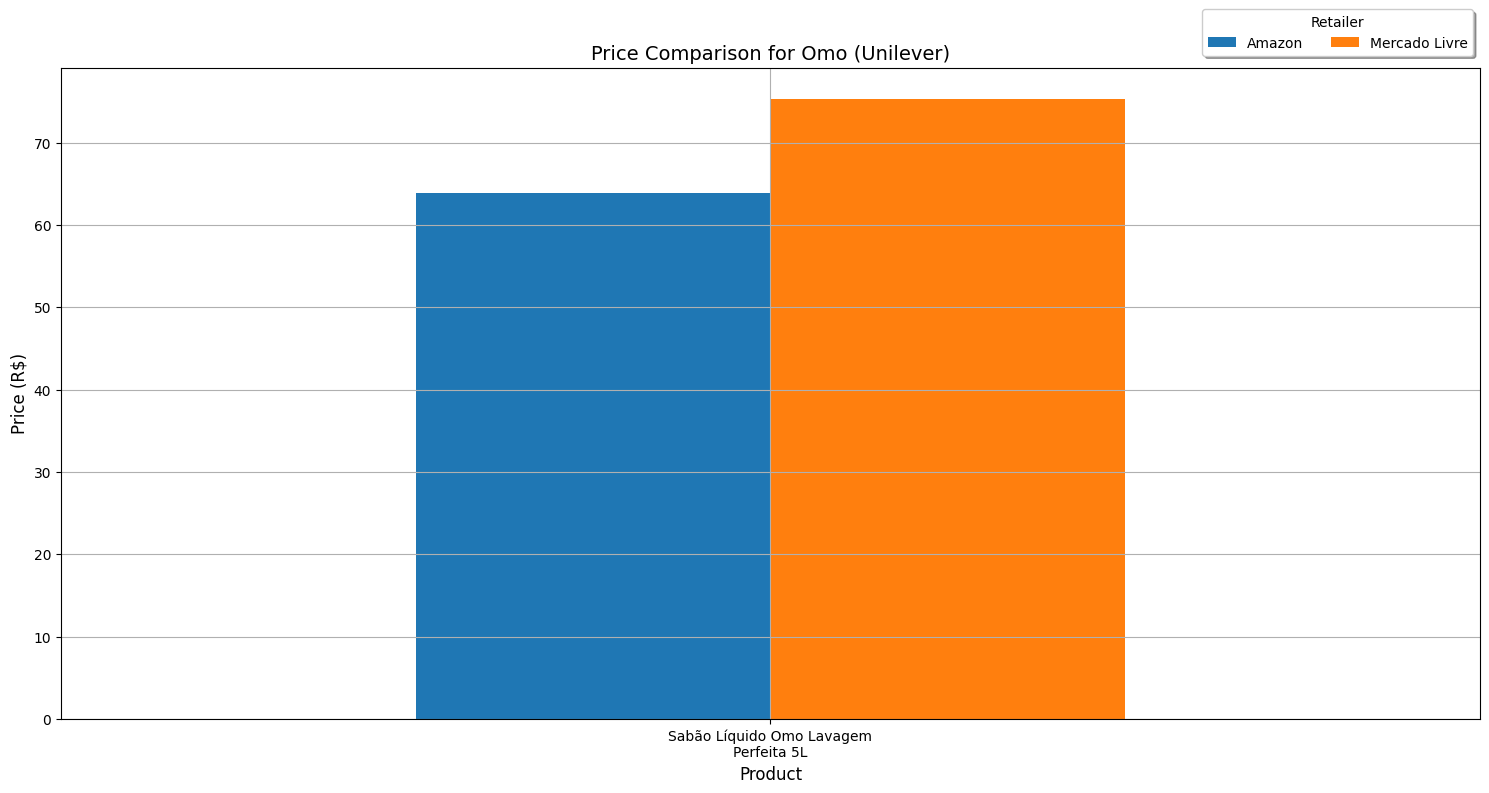

Retailer                                            Amazon  DrogaRaia  \
Product                                                                 
Sabonete em Barra Rexona Antibacterial Limpeza ...    4.44       2.64   

Retailer                                            Mercado Livre  
Product                                                            
Sabonete em Barra Rexona Antibacterial Limpeza ...           2.74  


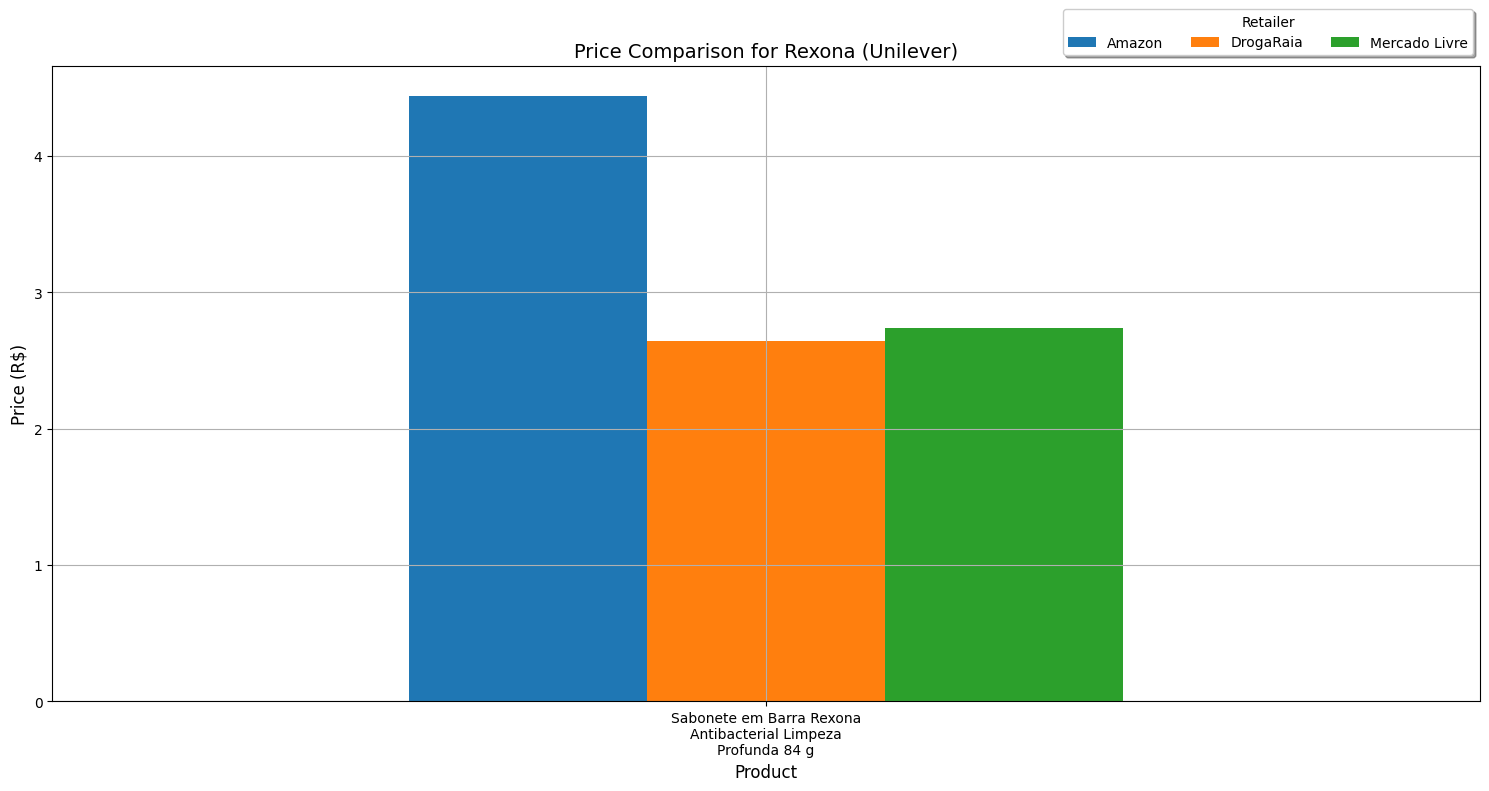

Retailer                                            Amazon  DrogaRaia
Product                                                              
Shampoo Seda By Niina Secrets Água Micelar + Hi...   15.24      15.99
Shampoo Seda By Rayza Babosa + Óleos 325ml           14.71      15.40
Shampoo Seda Ceramidas 325ml                         11.85      14.15
Tratamento Condicionador Seda Ceramidas 325ml        16.27      19.94


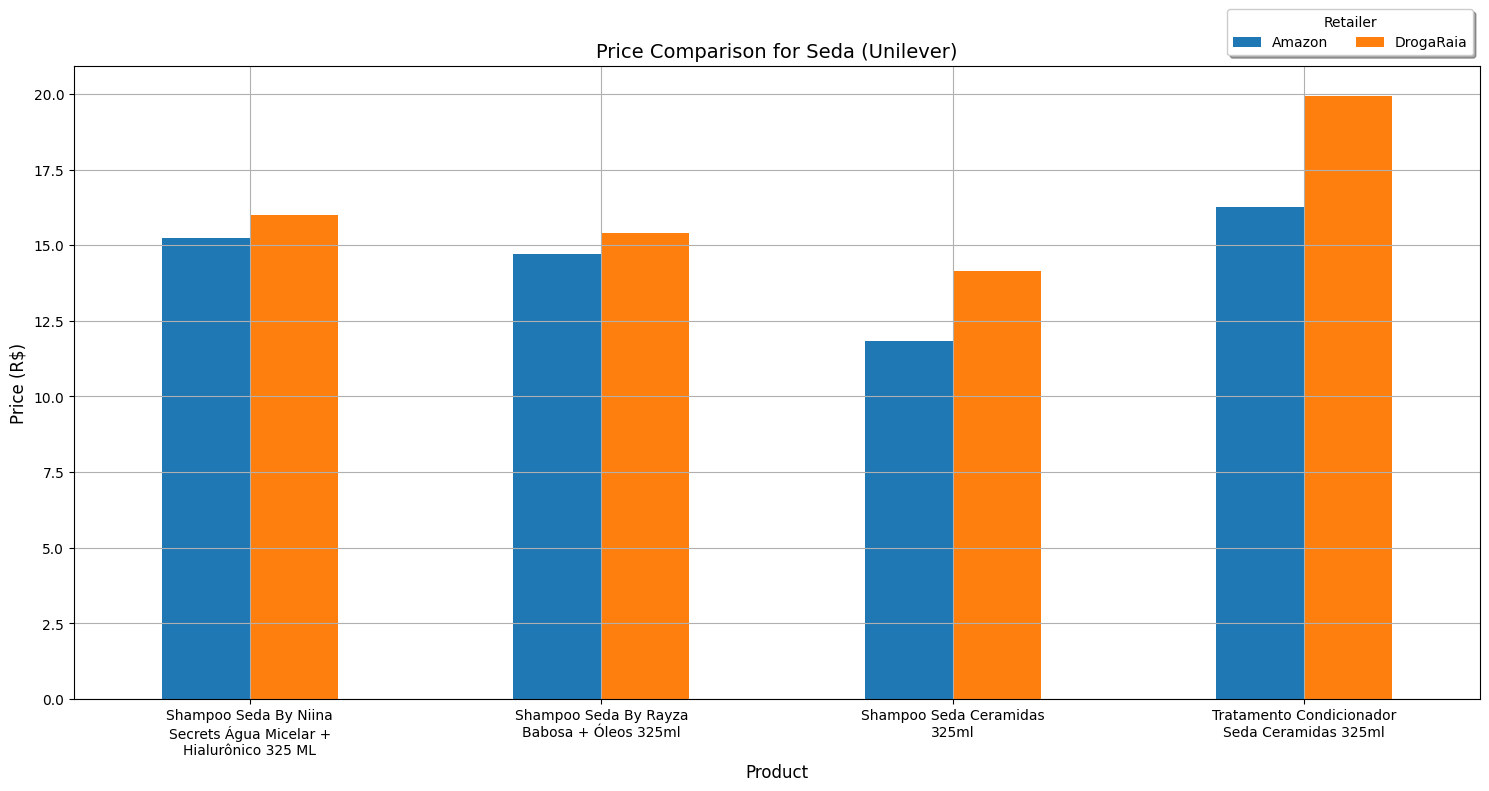

Retailer                                            Amazon  DrogaRaia
Product                                                              
Condicionador TRESemmé Hidratação Profunda 400ml     19.55      30.59
Condicionador TRESemmé Reconstrução e Força 400ml    33.69      31.07
Shampoo TRESemmé Detox Capilar 400 ml                14.09      25.89
Shampoo TRESemmé Reconstrução e Força cabelos m...   14.40      32.75


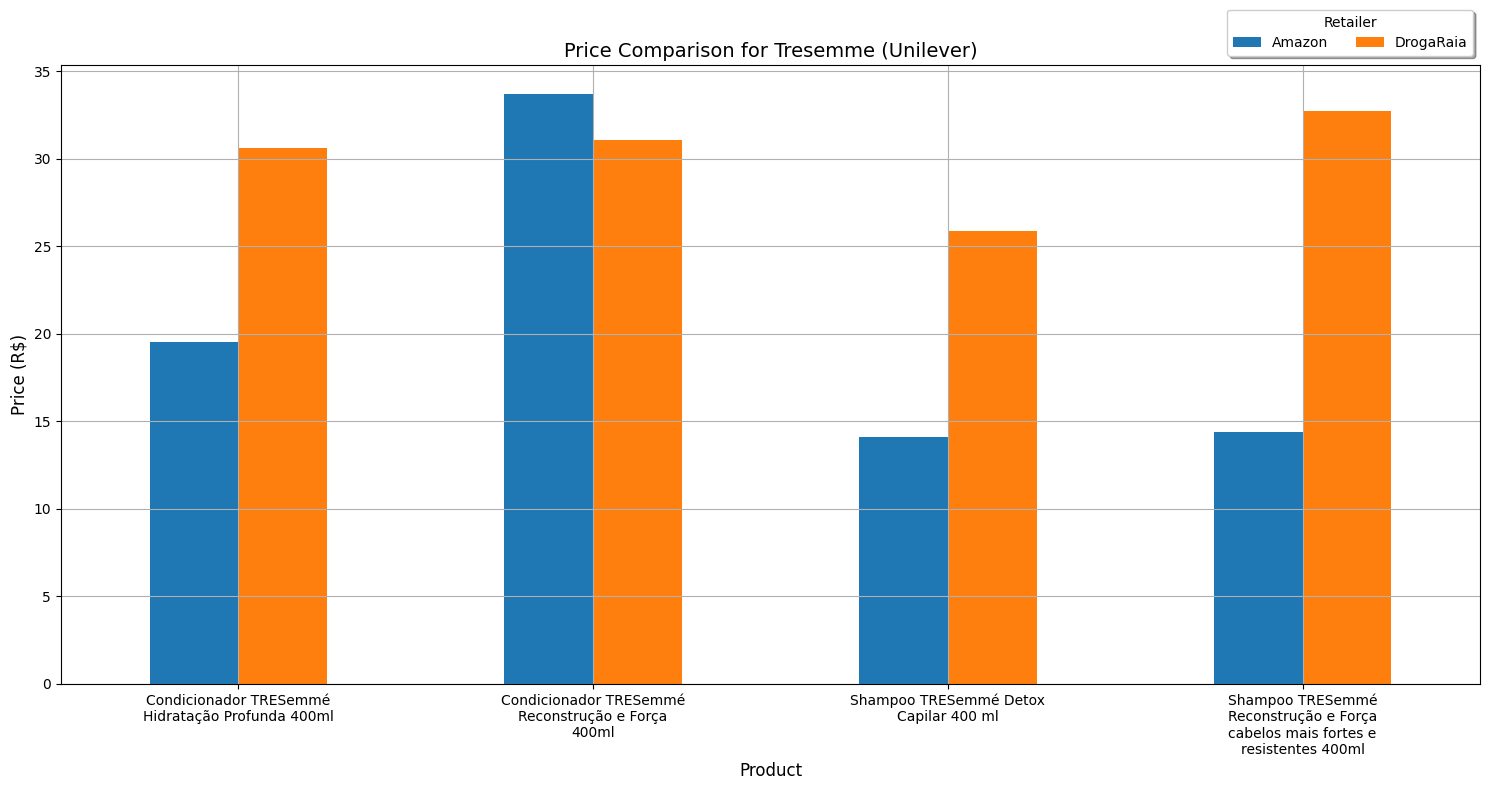

Retailer                      Amazon  Mercado Livre
Product                                            
Cloro Gel Vim Lavanda 700ml    12.72          17.85
Cloro Gel Vim Original 700ml   12.72          20.46


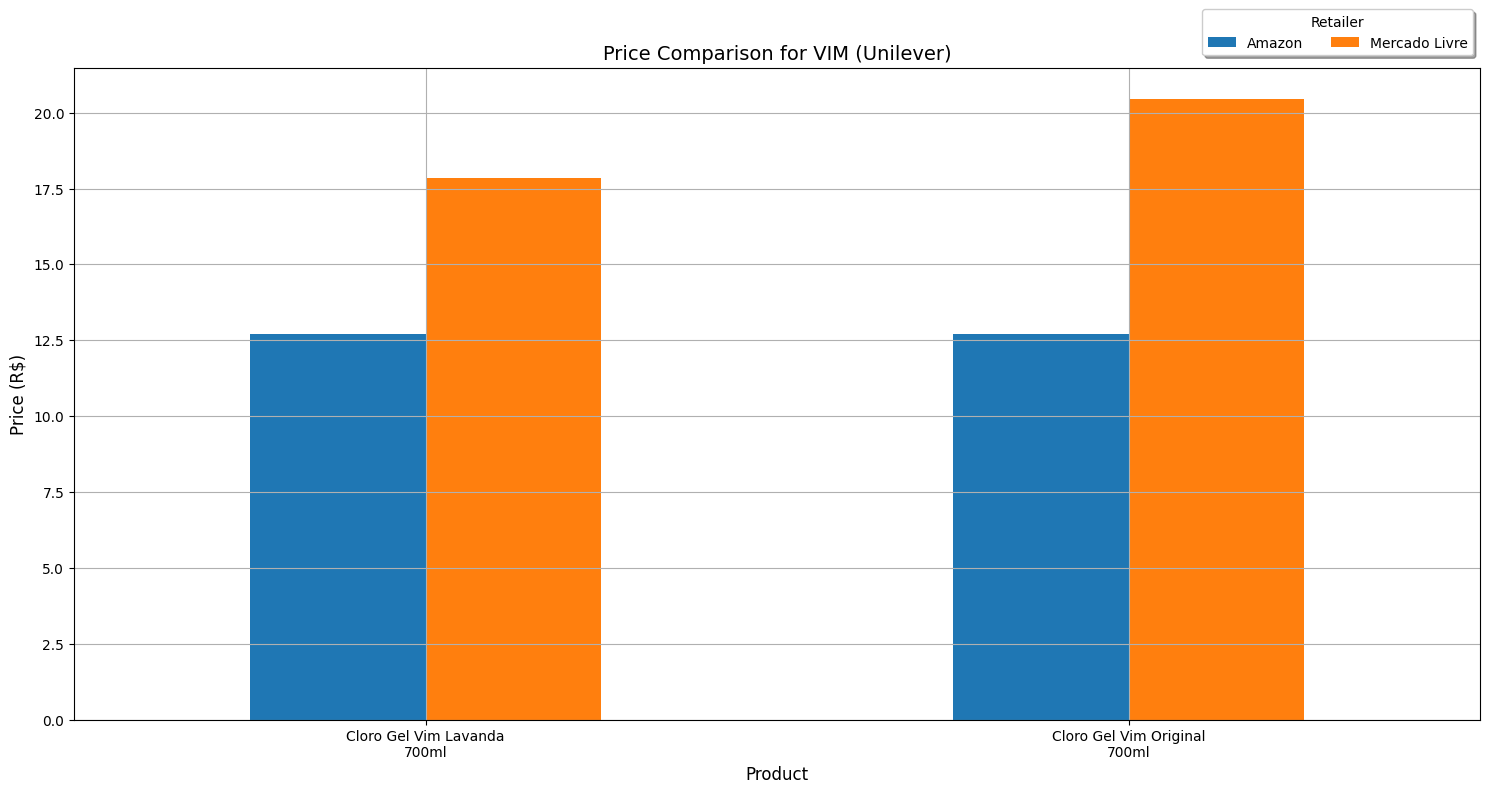

Empty DataFrame
Columns: []
Index: []


In [45]:
# Customer Price Analysis
selected_customer = 'Unilever'
selected_retailer = ['Amazon', 'DrogaRaia', 'Drogasil', 'Mercado Livre']
#selected_retailer = pd.unique()

df_join1 = df_prod.merge(right = df_coletas, how='inner',\
                    on = 'MasterKey_RetailerProduct').groupby(\
                        ["Customer","Specifics", "Competitor","Brand", "EAN", "Product", "Retailer"]\
                            ).mean()[["SuggestedPrice","FinalPrice"]]
df_join1["FinalPrice"] = np.round(df_join1["FinalPrice"].values,decimals = 2)
df_join1.reset_index(inplace = True)
df_join1

df_selected_customer = df_join1[(df_join1["Customer"] == selected_customer)&(df_join1["Competitor"] == 0)]

for brand in pd.unique(df_selected_customer["Brand"]):
    df_selected_brand = df_selected_customer[df_selected_customer["Brand"] == brand]
    
    # Group by EAN and Retailer, calculate mean price
    ean_retailer_prices = df_selected_brand.groupby(['EAN', 'Retailer','Product'])['FinalPrice'].mean().reset_index()
    ean_retailer_prices = ean_retailer_prices.merge(right = pd.DataFrame(selected_retailer, columns = ['Retailer']), how = 'inner')


    # Pivot the data for plotting
    pivot_data = ean_retailer_prices.pivot(index='Product', columns='Retailer', values='FinalPrice')
    pivot_data.dropna(inplace = True)
    
    print(pivot_data)

    if not pivot_data.empty:
        # Create a bar chart for each EAN
        #ax = pivot_data.plot(kind='bar')
        ax = pivot_data.plot(kind='bar', figsize=(15, 8))
        ax.set_xlabel('Product', fontsize=12)                                   # Xlabel font and size
        ax.set_ylabel('Price (R$)', fontsize=12)                                     # Ylabel font and size

        ax.set_title(f'Price Comparison for {brand} ({selected_customer})', fontsize=14)

        # Break xlabels into multiple lines using textwrap
        wrapped_xlabels = [textwrap.fill(label, width=25) for label in pivot_data.index]
        
        # Xlabel rotation and position 
        ax.set_xticklabels(wrapped_xlabels, rotation=0, ha='center', fontsize=10)    

        # Position the legend outside the chart
        ax.legend(title='Retailer', loc='upper right', 
                    bbox_to_anchor=(1.0, 1.1), ncol=3, 
                    fancybox=True, shadow=True,fontsize=10)                      # Legend font size

        # Add grid lines to the plot
        ax.grid(True)
        
        
        plt.tight_layout()
        plt.show()
    
 

C:\Users\luiza\AppData\Local\Temp\ipykernel_14860\3361598670.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_join2 = df_prod.merge(right = df_coletas, how='inner',\
C:\Users\luiza\AppData\Local\Temp\ipykernel_14860\3361598670.py:37: FutureWarning: The default value of regex will change from True to False in a future version.
  pivot_data.columns = pivot_data.columns.str.replace(r'^[A-Za-z]+[0-9]+','')


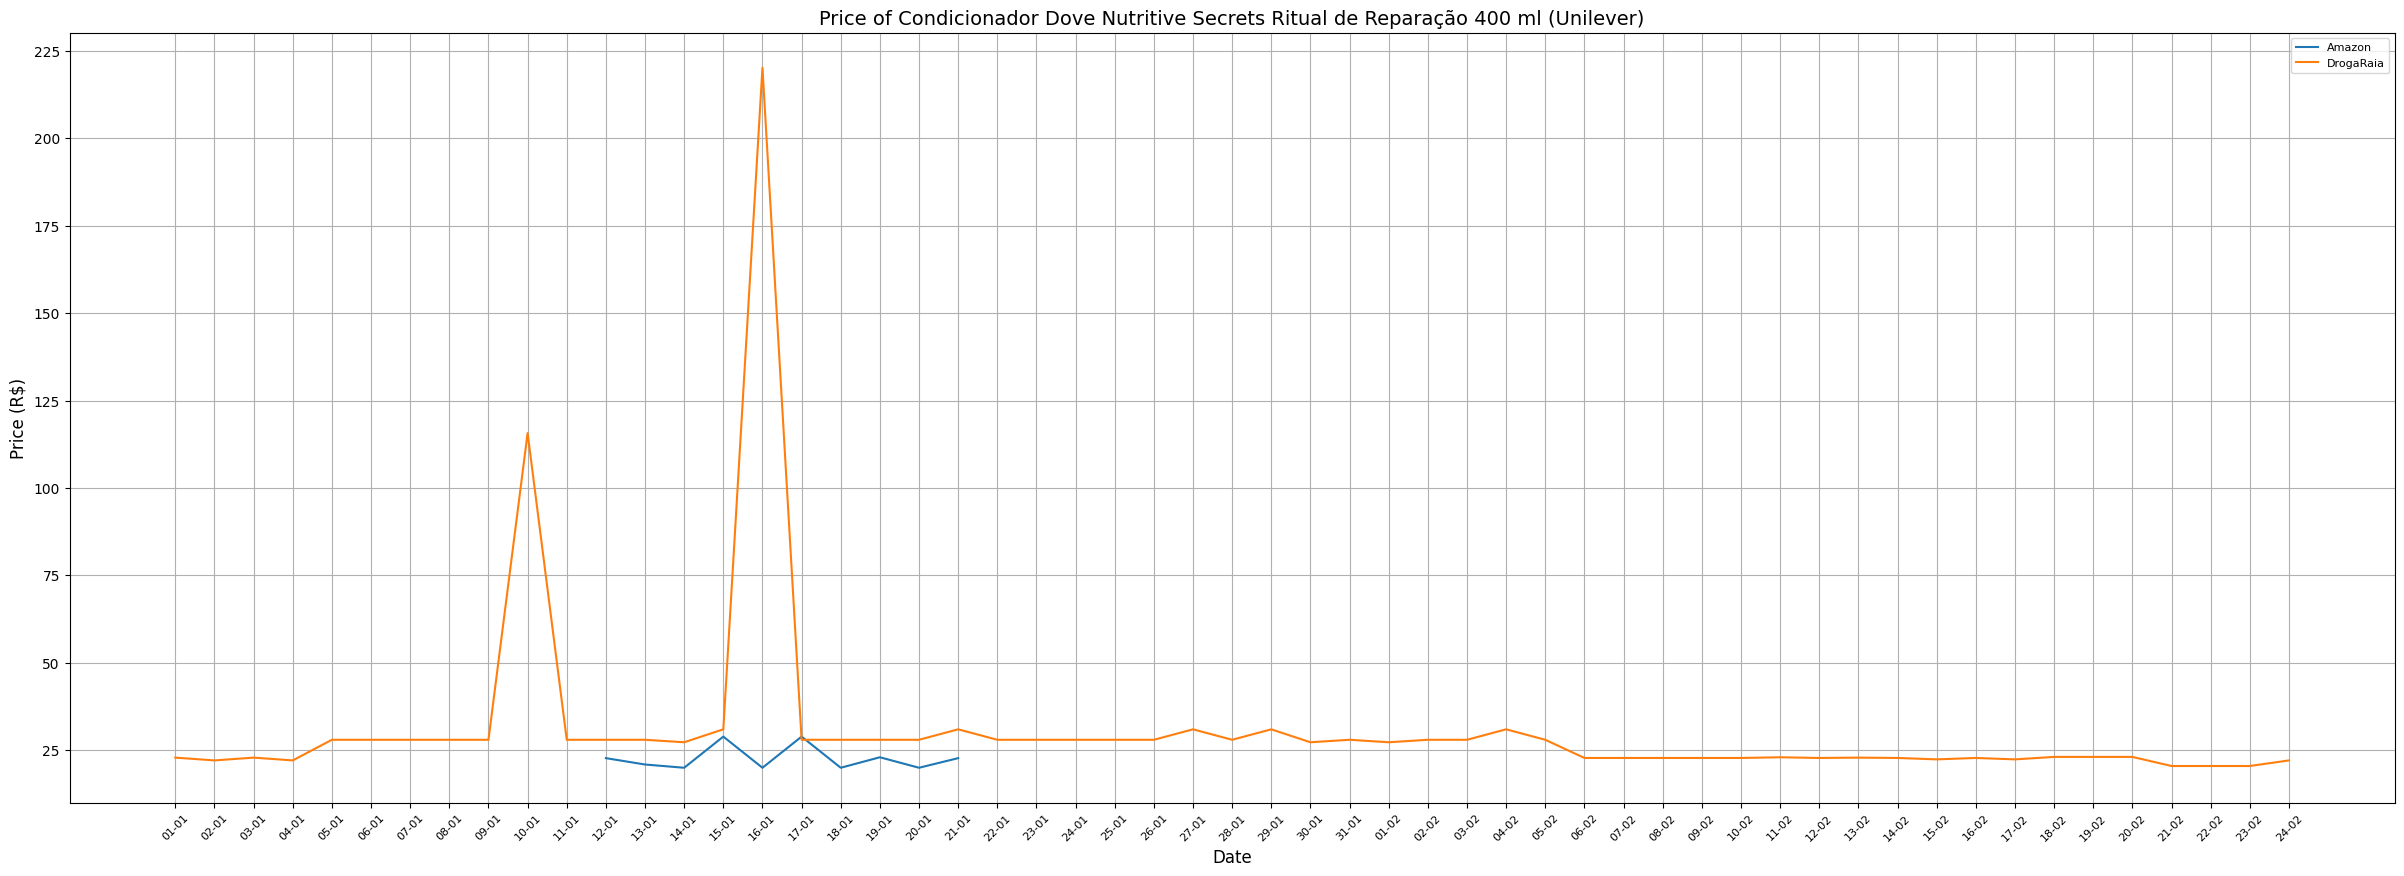

C:\Users\luiza\AppData\Local\Temp\ipykernel_14860\3361598670.py:37: FutureWarning: The default value of regex will change from True to False in a future version.
  pivot_data.columns = pivot_data.columns.str.replace(r'^[A-Za-z]+[0-9]+','')


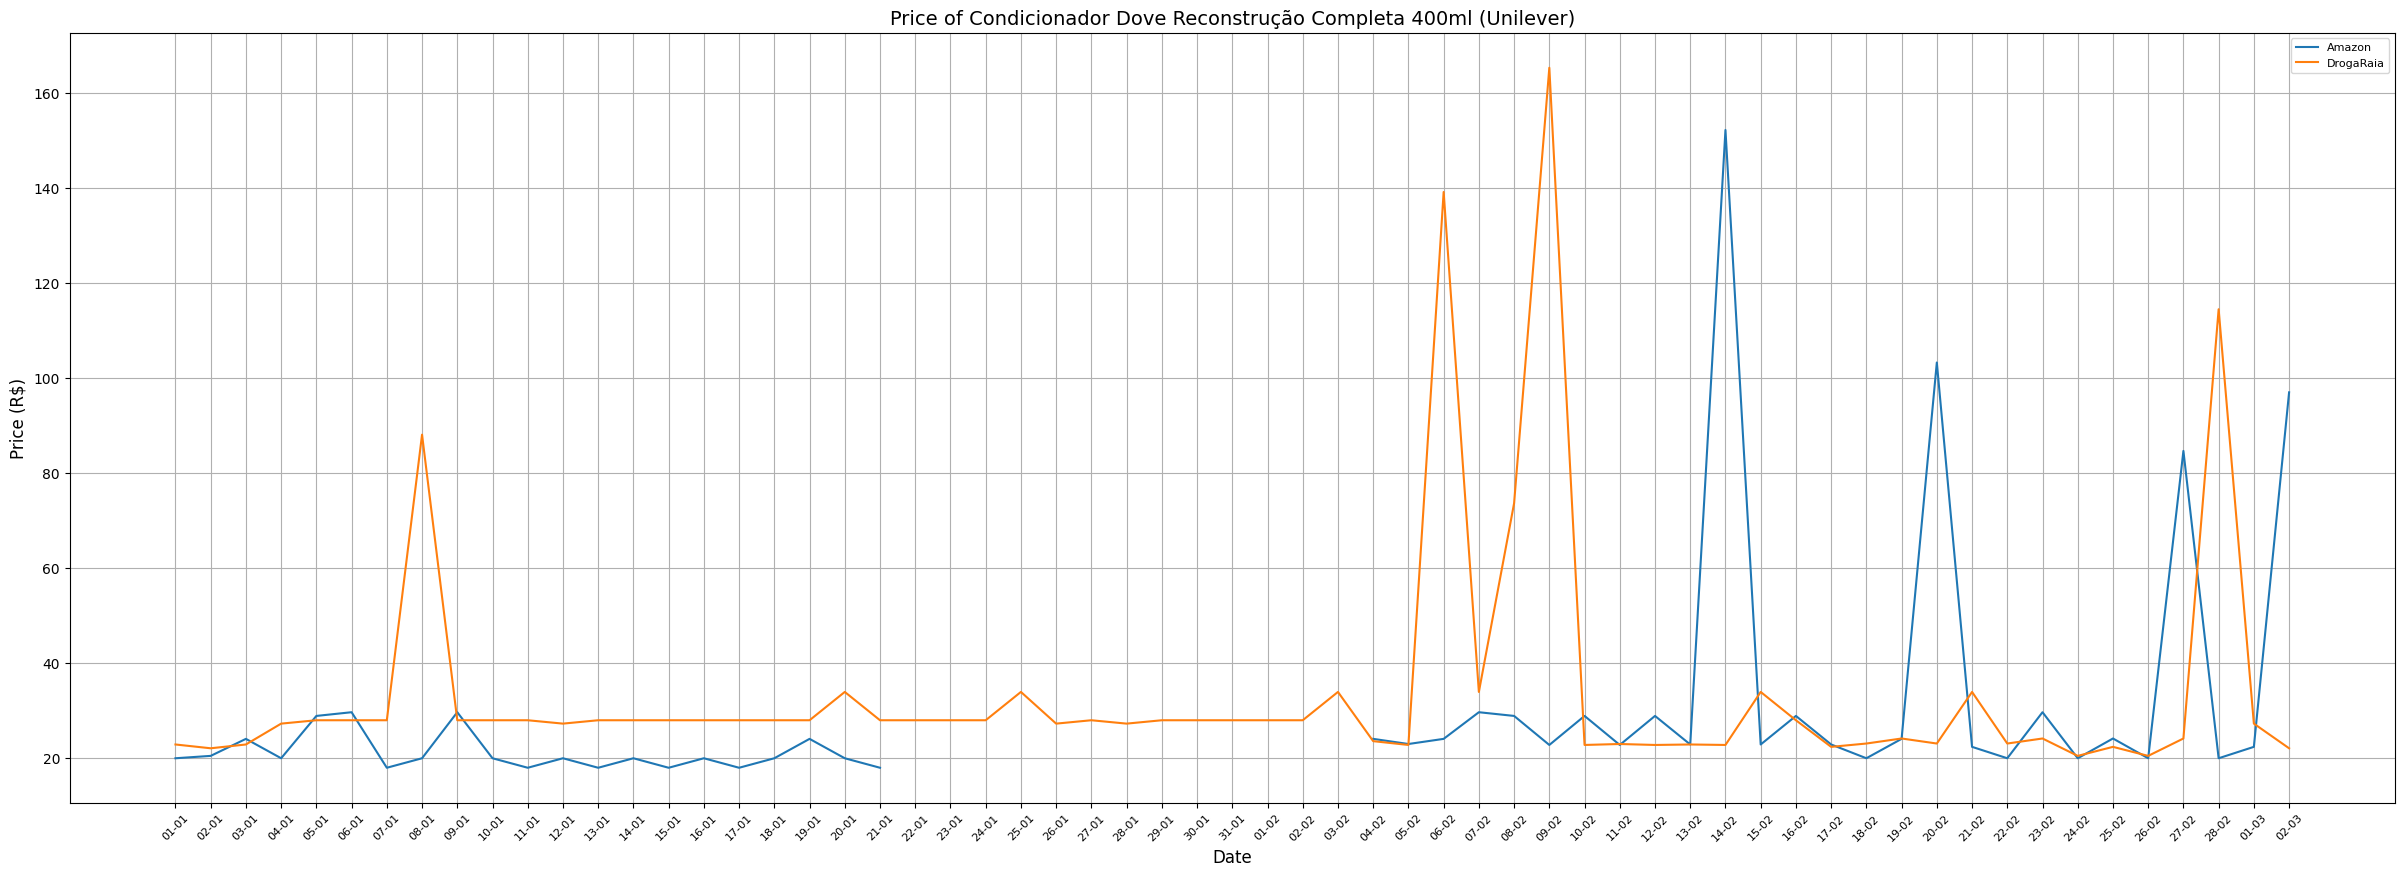

C:\Users\luiza\AppData\Local\Temp\ipykernel_14860\3361598670.py:37: FutureWarning: The default value of regex will change from True to False in a future version.
  pivot_data.columns = pivot_data.columns.str.replace(r'^[A-Za-z]+[0-9]+','')


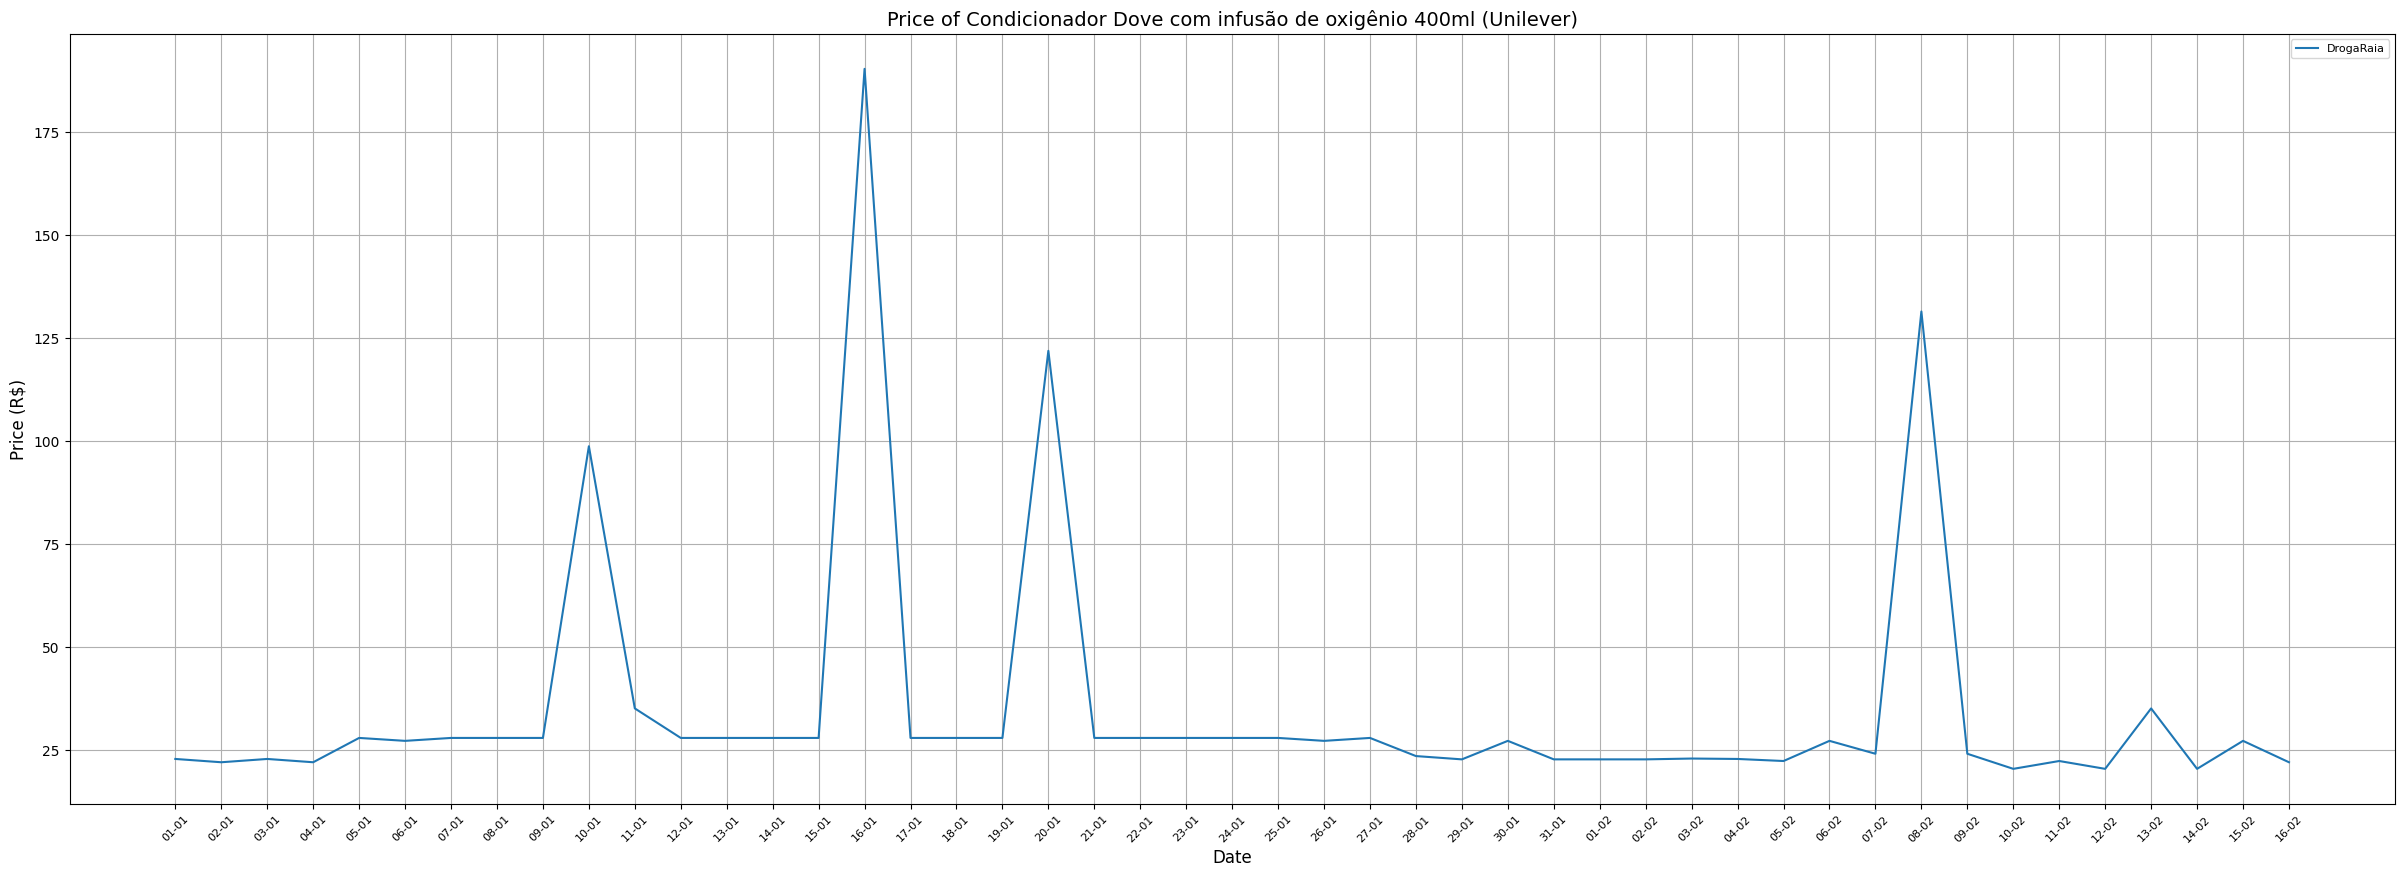

C:\Users\luiza\AppData\Local\Temp\ipykernel_14860\3361598670.py:37: FutureWarning: The default value of regex will change from True to False in a future version.
  pivot_data.columns = pivot_data.columns.str.replace(r'^[A-Za-z]+[0-9]+','')


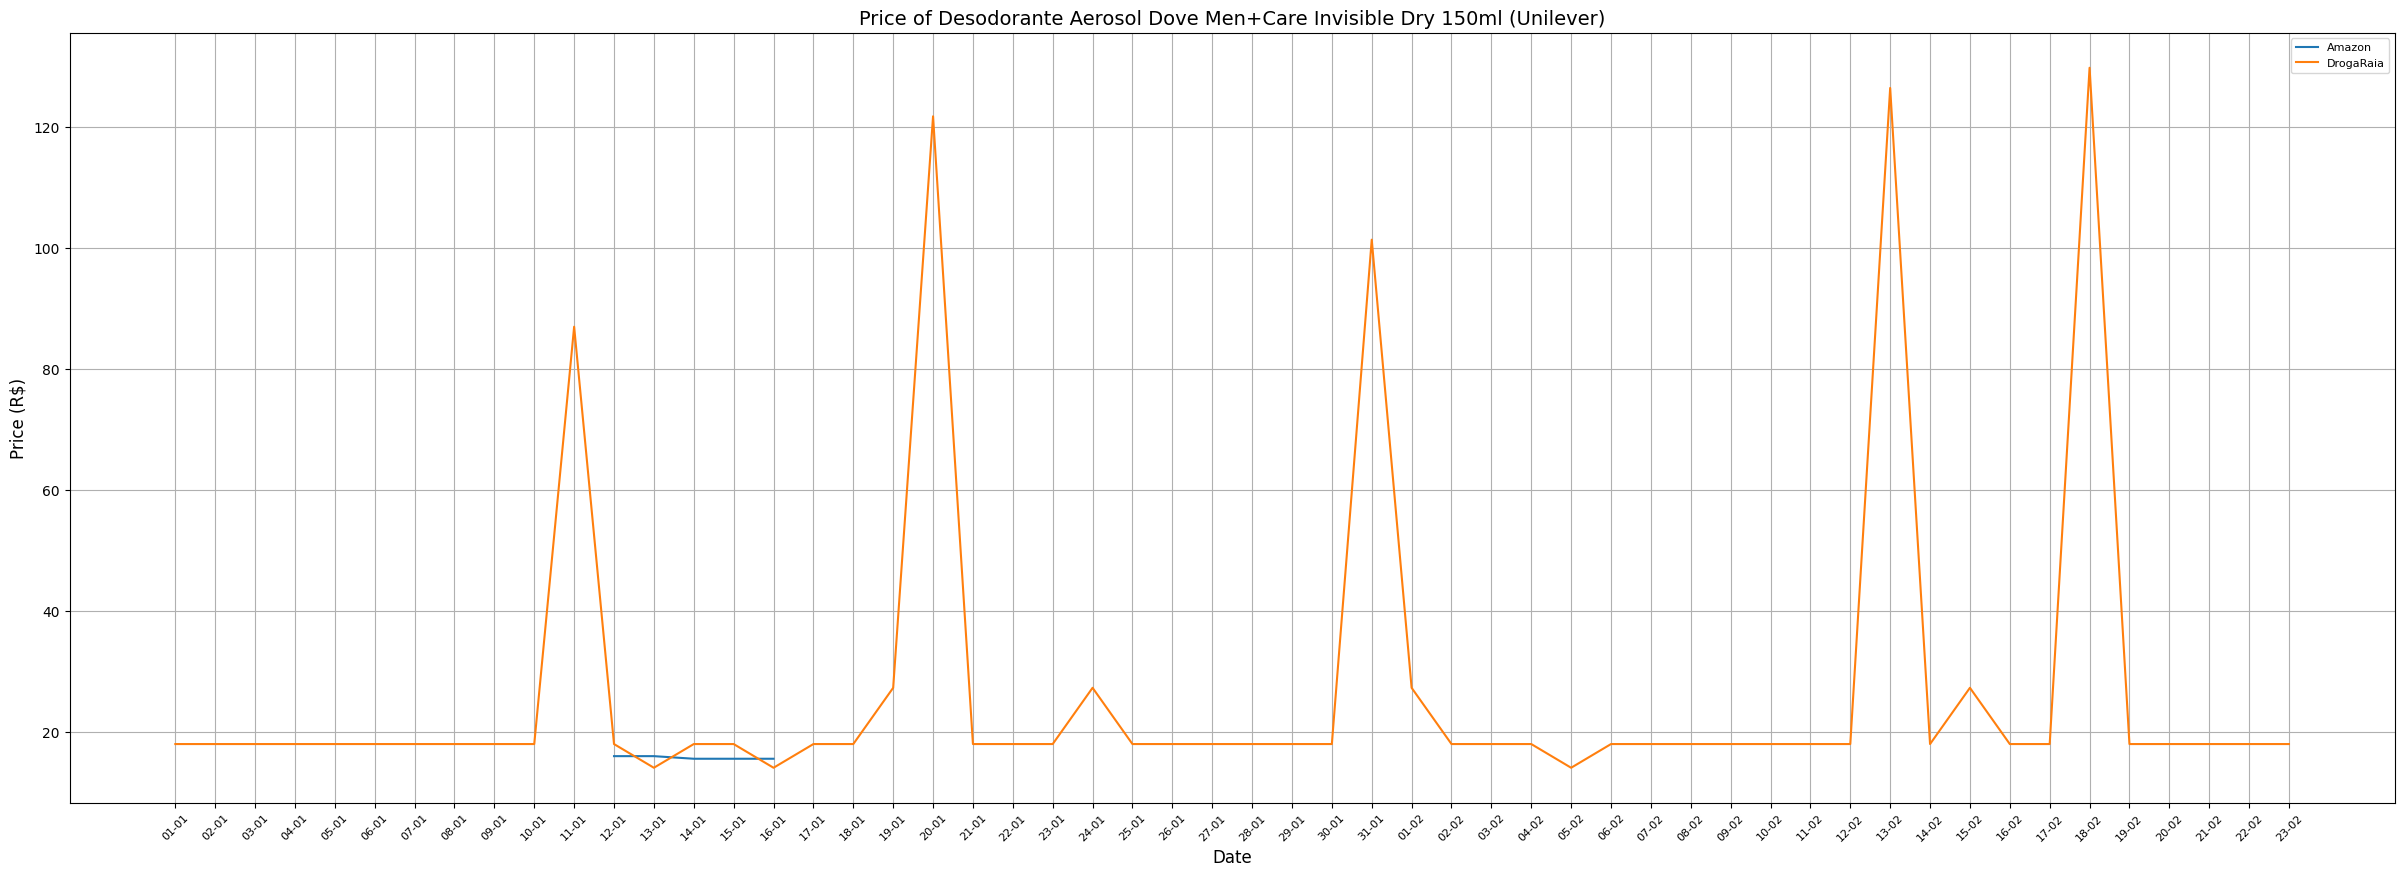

C:\Users\luiza\AppData\Local\Temp\ipykernel_14860\3361598670.py:37: FutureWarning: The default value of regex will change from True to False in a future version.
  pivot_data.columns = pivot_data.columns.str.replace(r'^[A-Za-z]+[0-9]+','')


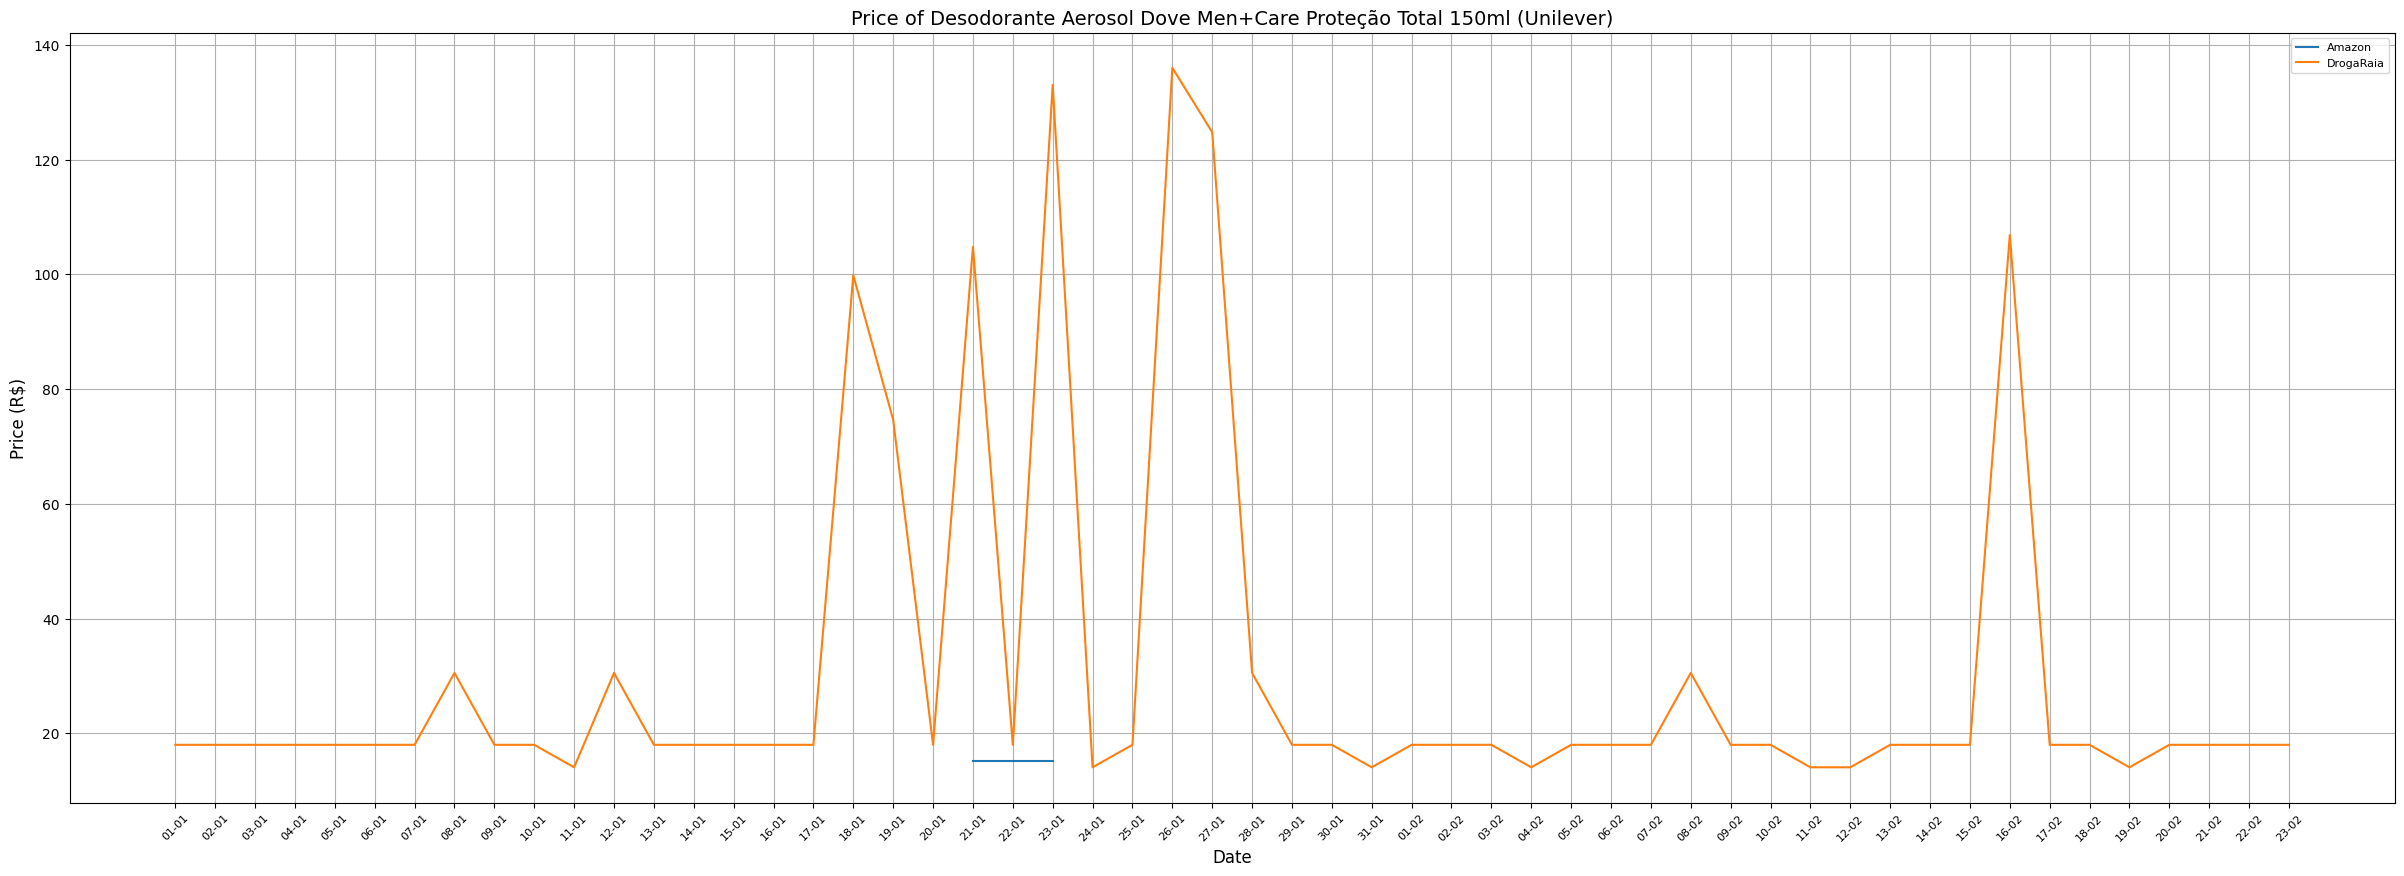

In [39]:
from matplotlib.dates import DateFormatter

# Customer Price Analysis
selected_customer = 'Unilever'      #--> Customer name 
selected_brand = 'Dove'             #--> Customer associated brand 

selected_retailers = ['Amazon', 'DrogaRaia', 'Drogasil', 'Mercado Livre']   #--> Retailers to be analized 

num_ean = 5                         # --> Number of selected_brand products which prices will be analized

df_join2 = df_prod.merge(right = df_coletas, how='inner',\
                        on = 'MasterKey_RetailerProduct').groupby(\
                                                                ['Customer','Specifics', 'Competitor', 'Product',
                                                                'Brand','EAN','Retailer','MasterKey_RetailerProduct',
                                                                'DateIns'])['FinalPrice','SuggestedPrice'].mean()


df_join2['FinalPrice'] = np.round(df_join2['FinalPrice'].values,decimals = 2)
df_join2.reset_index(inplace = True)

df_selected = df_join2[(df_join2['Customer'] == selected_customer)&
                                (df_join2['Brand'] == selected_brand)&
                                (df_join2['Competitor'] == 0)]


for ean in pd.unique(df_selected['EAN'])[0:num_ean]:
    df_ean = df_selected[df_selected['EAN'] == ean]
    prod = pd.unique(df_ean['Product'].values)[0]
    
    # Group by EAN and Retailer, calculate mean price
    ean_retailer_prices = df_ean.groupby(['MasterKey_RetailerProduct', 'Retailer',
                                        'DateIns'])['FinalPrice'].mean().reset_index()
    ean_retailer_prices = ean_retailer_prices.merge(right = pd.DataFrame(selected_retailer, columns = ['Retailer']), how = 'inner')
    
    # Pivot the data for plotting
    pivot_data = ean_retailer_prices.pivot(index='DateIns', columns='MasterKey_RetailerProduct', values='FinalPrice')
    pivot_data.columns = pivot_data.columns.str.replace(r'^[A-Za-z]+[0-9]+','')

    if not pivot_data.empty:
        # Create a chart
        fig, ax = plt.subplots(figsize=(30,10))


        for retailer in pd.unique(pivot_data.columns):
            ax.plot(pivot_data.index, pivot_data[retailer], label=retailer)

        ax.set_xlabel('Date', fontsize=12)                                      # Xlabel font and size
        ax.set_ylabel('Price (R$)', fontsize=12)                                     # Ylabel font and size

        ax.set_title(f'Price of {prod} ({selected_customer})', fontsize=14)

        # xlabels datetime formatting
        date_formatter = DateFormatter('%d-%m')  # Define the desired format
        ax.xaxis.set_major_formatter(date_formatter)
        plt.xticks(rotation=45, ha='center', fontsize=8)                         # Xlabel rotation and position   

        ax.legend(loc='best')                                                   # Legend position 
        ax.legend(fontsize=8)                                                   # Legend font size
    
        # Add grid lines to the plot
        ax.grid(True)

        #plt.tight_layout()
        plt.show()


In [40]:
def descriptive_stats(prices):  
    
    # Create a Pandas Series
    price_series = pd.Series(prices)

    # Basic descriptive statistics
    mean_price = price_series.mean()
    median_price = price_series.median()
    std_deviation = price_series.std()
    min_price = price_series.min()
    max_price = price_series.max()

    # Calculate IQR for outlier detection
    q1 = price_series.quantile(0.25)
    q3 = price_series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Outliers
    outliers = price_series[(price_series < lower_bound) | (price_series > upper_bound)]

    # Plot box plot to visualize distribution and outliers
    plt.figure(figsize=(8, 6))
    plt.boxplot(price_series, vert=False)
    plt.title("Price Distribution and Outliers")
    plt.xlabel("Price")
    plt.ylabel("Value")
    plt.show()

    # Print descriptive statistics and outliers
    print("Descriptive Statistics:")
    print("Mean:", mean_price)
    print("Median:", median_price)
    print("Standard Deviation:", std_deviation)
    print("Min:", min_price)
    print("Max:", max_price)

    print("\nOutliers:")
    print(outliers)

    return None

C:\Users\luiza\AppData\Local\Temp\ipykernel_14860\2881460370.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_join3 = df_prod.merge(right = df_coletas, how='inner',\


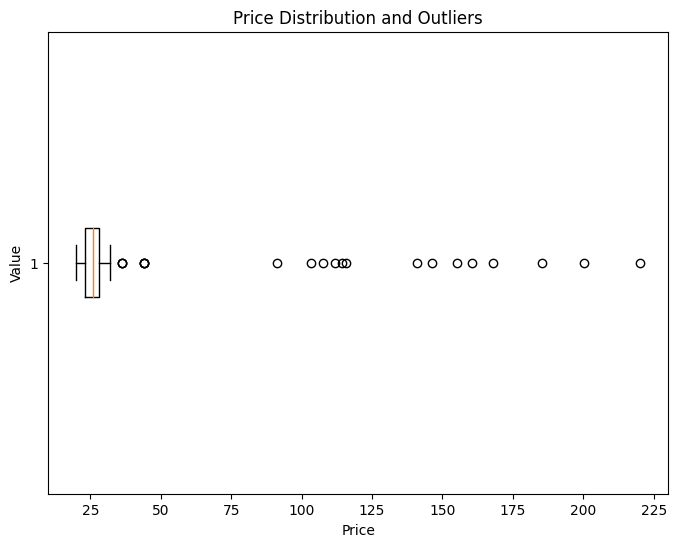

Descriptive Statistics:
Mean: 35.168212290502794
Median: 25.99
Standard Deviation: 33.898385532794336
Min: 19.99
Max: 220.15

Outliers:
30     115.69
36     220.15
85     200.42
89      36.34
92     160.55
100    146.35
102     36.34
105     36.34
115    114.32
134     91.15
136     44.06
137    155.02
138    112.00
147     44.06
155    141.14
156     44.06
158    103.37
161    107.76
172    167.97
174    185.32
175     44.06
dtype: float64


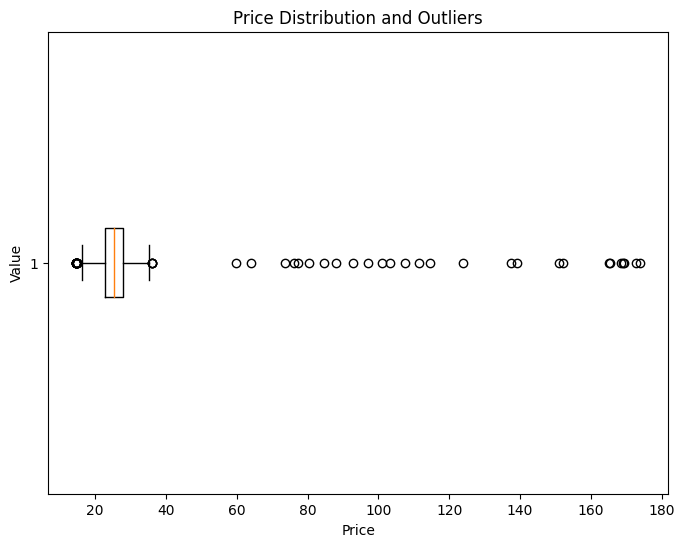

Descriptive Statistics:
Mean: 31.377190721649484
Median: 25.22
Standard Deviation: 26.357775784082097
Min: 14.69
Max: 173.85

Outliers:
21      77.33
37     152.23
43     103.29
50      84.68
53      97.01
61      88.10
90     139.18
92      73.66
93     165.33
112    114.50
121    169.29
139    111.52
144    169.12
174    137.31
181    123.74
188    173.85
210    100.90
223     36.09
233    150.88
234     36.09
235     36.09
238     36.09
246    165.18
252    168.36
274    172.78
328     80.51
342     14.92
344     14.92
346     14.92
348     14.92
350     59.89
351     14.69
352     14.92
365     92.82
366     63.92
368     14.69
369     76.06
372     14.69
374     14.69
376     14.69
378     14.69
379    107.61
380     14.69
382     14.69
384     14.69
dtype: float64


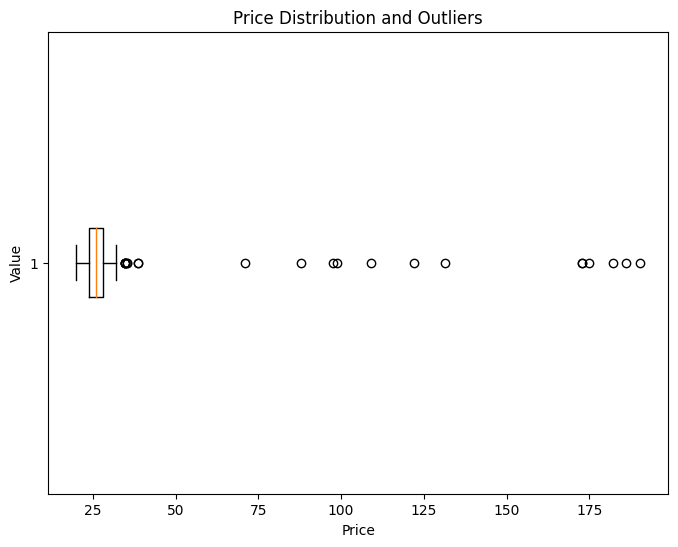

Descriptive Statistics:
Mean: 36.25007042253521
Median: 25.99
Standard Deviation: 34.99577096023731
Min: 19.99
Max: 190.31

Outliers:
9       98.75
10      35.15
15     190.31
19     121.90
38     131.44
43      35.15
48      34.80
49      34.80
56      34.80
58      87.97
73     109.18
75      97.54
81     182.18
83      34.80
85      34.80
117    174.84
118     70.90
121     38.75
124    172.72
130     38.75
135    186.22
141    172.87
dtype: float64


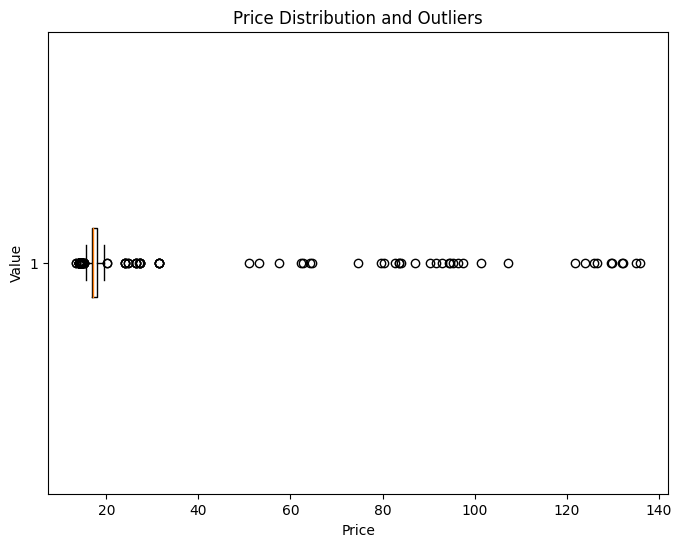

Descriptive Statistics:
Mean: 24.560381679389312
Median: 17.13
Standard Deviation: 23.469041236011808
Min: 13.49
Max: 135.9

Outliers:
7      14.79
8      14.79
9      14.79
10     15.10
11     79.71
       ...  
358    64.24
369    20.09
375    62.30
377    80.36
386    14.00
Length: 93, dtype: float64


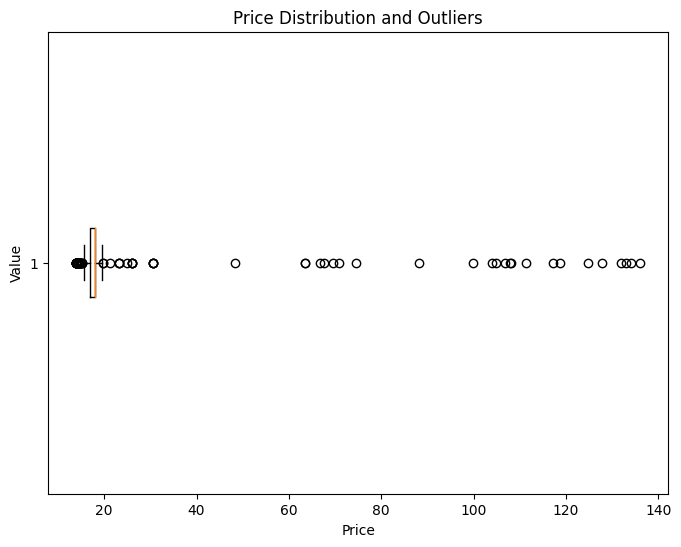

Descriptive Statistics:
Mean: 24.93733082706767
Median: 17.99
Standard Deviation: 24.860456772992695
Min: 13.98
Max: 136.0

Outliers:
0       19.78
1       13.99
2       13.99
7       15.10
8       15.10
        ...  
225     13.98
239    131.95
252    111.24
255     14.00
265     21.31
Length: 76, dtype: float64


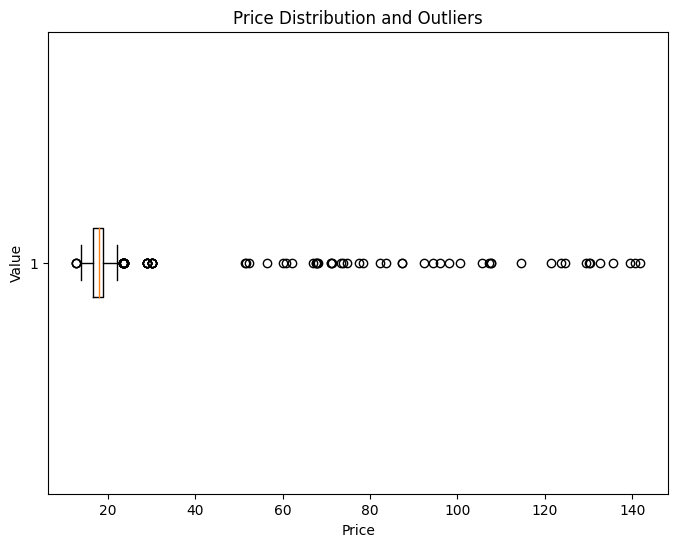

Descriptive Statistics:
Mean: 23.71916221033868
Median: 17.99
Standard Deviation: 21.806591070552127
Min: 12.85
Max: 141.75

Outliers:
0       92.30
27      87.34
33      60.20
72      98.10
78      52.31
        ...  
516    140.55
520     23.62
542    141.75
544     23.62
560     23.62
Length: 76, dtype: float64


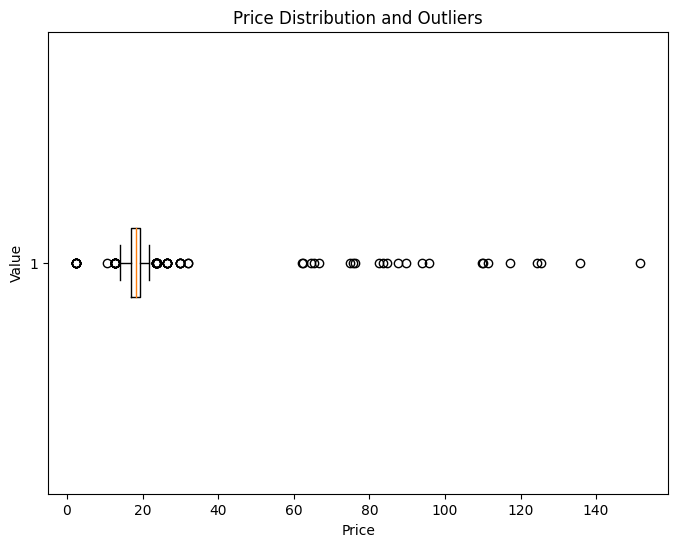

Descriptive Statistics:
Mean: 22.85385507246377
Median: 18.17
Standard Deviation: 20.372383650875754
Min: 2.49
Max: 151.6

Outliers:
35     12.79
37     12.79
39     12.79
41     12.79
43     12.79
       ...  
313    87.68
316    83.58
319    89.60
336    23.64
342    23.64
Length: 74, dtype: float64


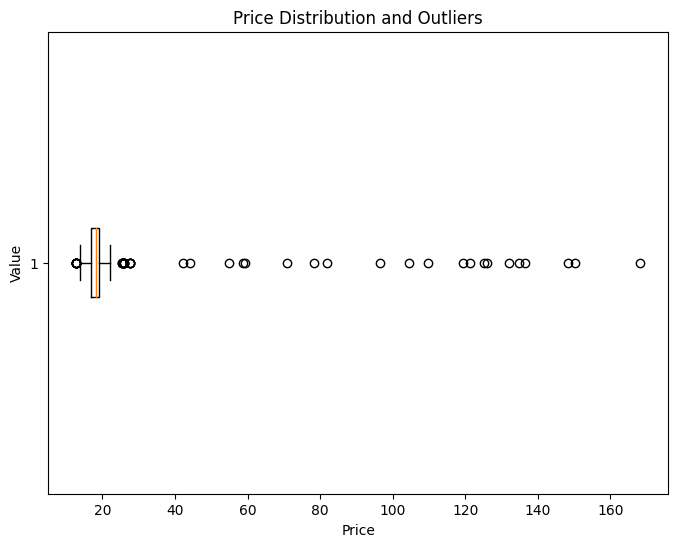

Descriptive Statistics:
Mean: 21.94501118568233
Median: 18.17
Standard Deviation: 19.869829833493345
Min: 12.79
Max: 168.16

Outliers:
2       44.06
46      12.79
48      12.79
50      12.79
52      12.79
54      12.79
56      12.79
58      12.79
60      54.84
62      12.79
66      12.79
70      12.79
71      12.79
72      12.79
132     96.49
133    131.97
136     25.93
148     78.40
153     82.02
154     25.93
156     25.93
159     25.93
181    150.24
184     25.40
187     25.40
194     25.40
205    119.42
215    121.22
282     70.91
286     25.70
288    109.76
292     25.70
300     25.70
305    136.54
309     25.70
316     25.70
318     58.61
323    104.45
335     27.45
339    126.01
346     42.24
347    168.16
361     27.45
363     27.45
365    148.42
372     27.45
375    125.09
379     27.45
432     59.30
442    134.68
dtype: float64


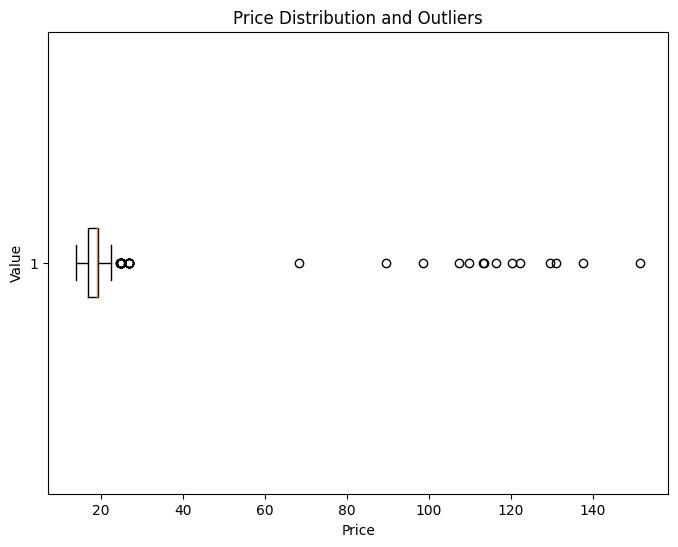

Descriptive Statistics:
Mean: 23.99657370517928
Median: 18.99
Standard Deviation: 22.815939345412577
Min: 13.99
Max: 151.57

Outliers:
2       26.90
4       26.90
6       89.65
7       26.90
13      68.33
18      26.90
21      26.90
22     109.87
23     131.13
36      26.90
41      26.90
43      26.90
74     113.24
75     116.41
98      24.95
101     24.95
106     24.95
109    107.30
115     24.95
122     24.95
130     24.95
132     24.95
133     98.56
134    129.68
137     24.95
140     24.95
168    151.57
175    113.53
200     24.56
207    137.70
218     24.56
230    120.27
233    122.20
248     24.56
dtype: float64


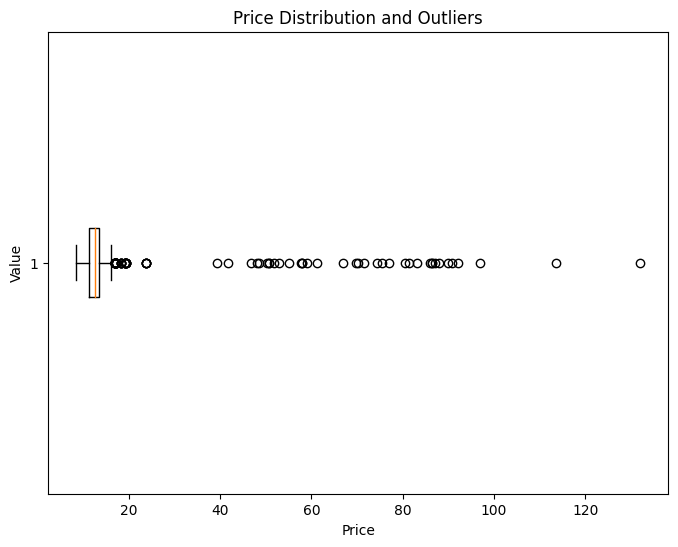

Descriptive Statistics:
Mean: 17.666203904555314
Median: 12.49
Standard Deviation: 16.973705576364733
Min: 8.49
Max: 131.97

Outliers:
5      80.39
43     96.95
66     69.77
74     19.34
82     50.75
       ...  
409    16.99
410    16.99
411    16.99
412    23.79
431    77.09
Length: 97, dtype: float64


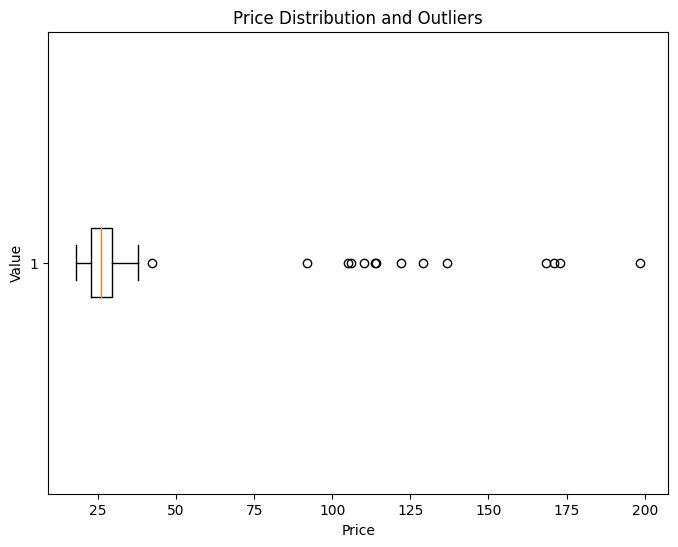

Descriptive Statistics:
Mean: 32.67688118811881
Median: 25.9
Standard Deviation: 28.048354740651995
Min: 18.06
Max: 198.49

Outliers:
12     121.98
28     110.12
29     104.88
36     113.61
47     168.37
48      91.88
63     136.85
68      42.14
69     129.00
74     198.49
85     172.74
96     170.87
140    106.05
147    114.00
dtype: float64


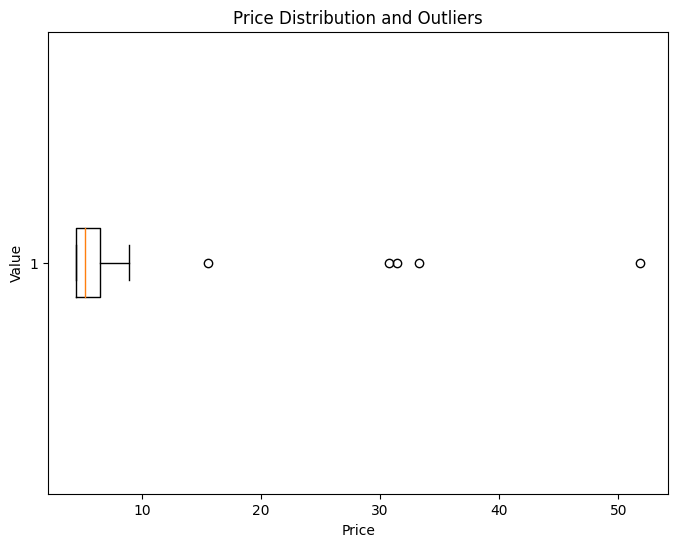

Descriptive Statistics:
Mean: 7.008024691358024
Median: 5.19
Standard Deviation: 7.26474903554023
Min: 4.49
Max: 51.82

Outliers:
5     51.82
24    31.44
39    33.27
42    15.56
60    30.72
dtype: float64


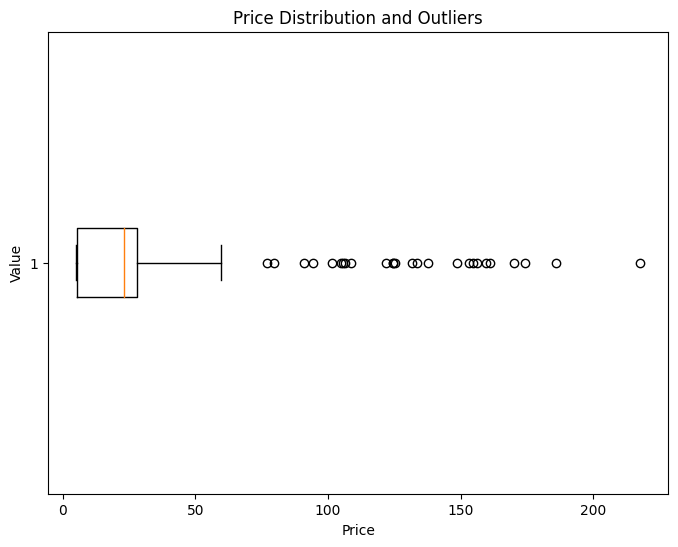

Descriptive Statistics:
Mean: 27.355260663507114
Median: 22.9
Standard Deviation: 30.255543969754775
Min: 5.1
Max: 217.67

Outliers:
5      106.53
6      186.05
7      108.55
15      94.30
16     174.29
17     124.66
22     148.69
54      76.91
81     159.75
92     153.22
93     101.40
105    217.67
111    161.19
129    170.16
148    133.41
175    156.29
181     91.07
202    104.81
213    125.14
257    131.86
280    124.69
296     79.56
318    154.59
324    137.63
349    121.86
370    105.57
dtype: float64


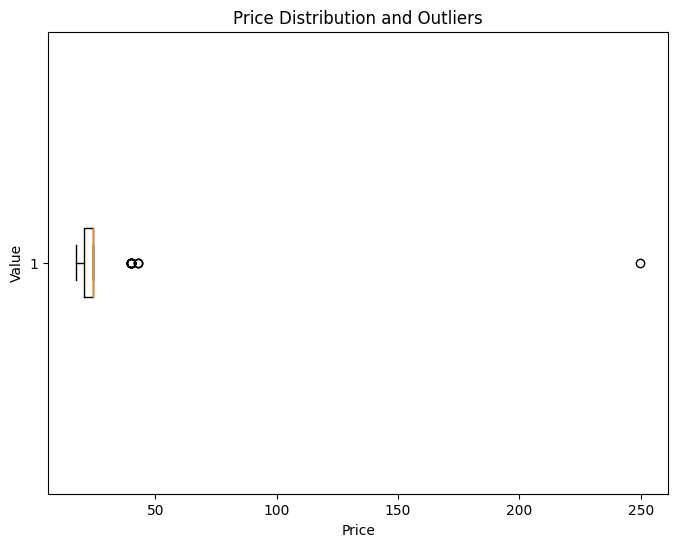

Descriptive Statistics:
Mean: 26.441056338028176
Median: 24.15
Standard Deviation: 19.908398267346165
Min: 17.49
Max: 249.65

Outliers:
61     39.90
62     39.90
63     39.90
64     39.90
65     39.90
68     39.90
69     39.90
70     39.90
71     39.90
73     39.90
74     39.90
76     39.90
78     39.90
80     42.87
82     42.94
83     39.90
84     42.87
85    249.65
86     39.90
87     39.90
dtype: float64


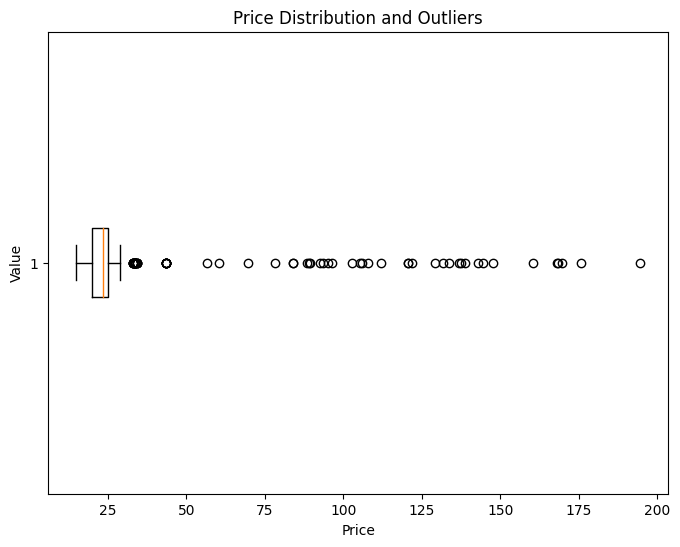

Descriptive Statistics:
Mean: 29.44796905222437
Median: 23.39
Standard Deviation: 26.243768738720505
Min: 14.99
Max: 194.42

Outliers:
5      105.19
7       56.61
12      69.56
78      96.23
94     136.75
        ...  
374     34.17
381     34.17
397    105.87
407    138.86
411     78.22
Length: 63, dtype: float64


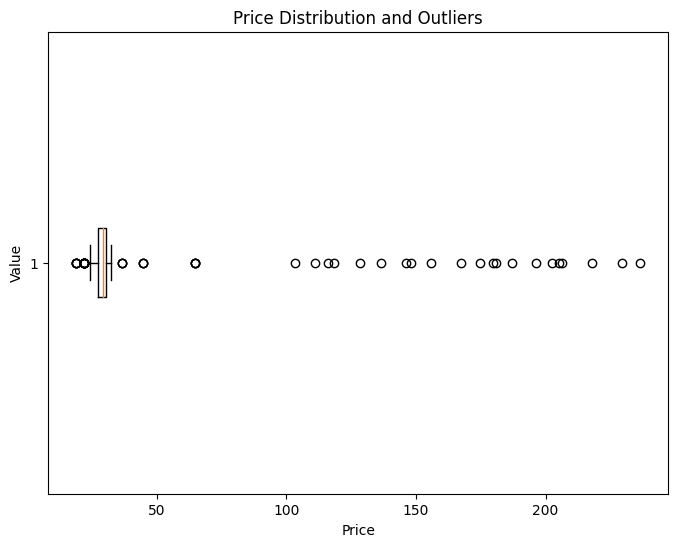

Descriptive Statistics:
Mean: 40.70272
Median: 29.19
Standard Deviation: 40.96446983125527
Min: 18.99
Max: 236.43

Outliers:
1       21.89
3       21.89
5      103.26
14     205.02
18      21.89
19      21.89
23     186.97
24     136.69
26      44.53
28     110.98
32     206.20
33     180.84
46      44.53
62      44.53
72     202.44
76      64.61
84      64.61
85     217.83
87      64.61
91     196.44
92     179.59
98      64.61
101    236.43
103    147.92
105    155.77
107    229.56
113    174.85
155     21.89
156     21.89
161     21.89
163     21.89
165    167.23
167     21.89
169    146.27
171     36.71
173     21.89
175     21.89
177     21.89
179     21.89
181     21.89
183     21.89
187     21.89
191     36.71
196     36.71
198     21.89
199    128.46
200     21.89
202    116.06
203     18.99
204     18.99
205     18.99
206     18.99
210     18.99
240    118.32
dtype: float64


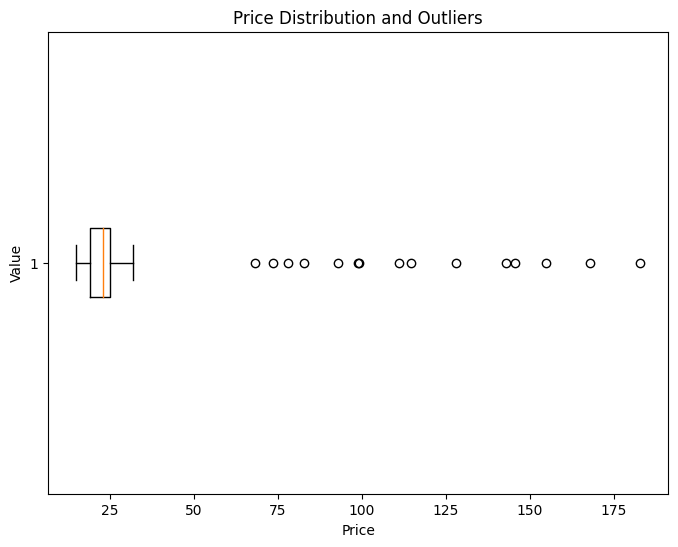

Descriptive Statistics:
Mean: 27.05513618677043
Median: 22.99
Standard Deviation: 23.95695322639206
Min: 14.99
Max: 182.71

Outliers:
44     128.05
45      99.01
51     110.87
74     142.95
75     182.71
118     98.89
131    145.41
133     92.77
134    154.70
149     68.10
188     82.62
196    114.45
197    167.70
211     78.01
245     73.41
dtype: float64


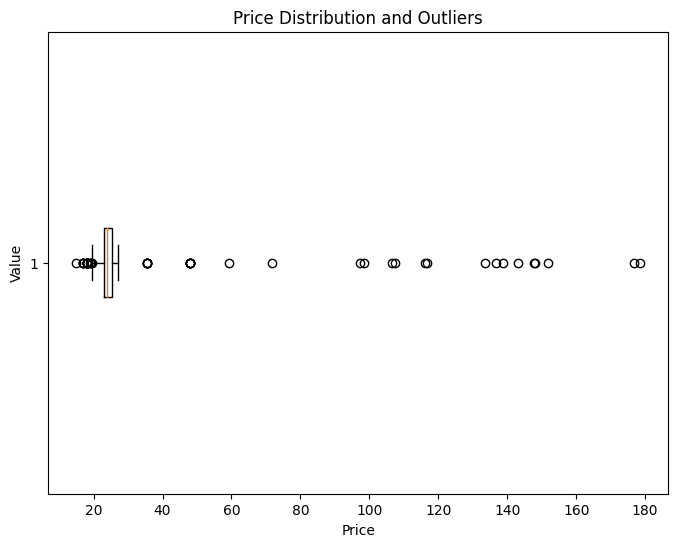

Descriptive Statistics:
Mean: 36.33615384615384
Median: 23.99
Standard Deviation: 35.10485588823734
Min: 14.99
Max: 178.5

Outliers:
0       19.19
1       19.19
5      176.71
6      136.59
11     133.44
12     143.22
16     107.33
17      47.85
19     151.88
20      47.85
25      47.85
27      47.85
28      19.19
30      59.29
31     116.11
32      19.39
34      47.85
36     116.58
39     148.09
41      18.89
42      47.85
50      35.44
51     106.67
60      35.44
69     138.70
70     147.71
74     178.50
76      35.44
81      35.44
82      35.44
90      14.99
97      17.99
98      16.99
99      17.99
100     16.99
101     17.99
102     17.99
104     17.99
105     17.99
106     17.99
107     17.99
108     71.63
109     16.99
110     17.99
111     16.99
113     17.99
114     97.40
115     98.58
118     17.99
119     17.99
121     17.99
125     17.99
dtype: float64


In [41]:
# Customer Price Analysis
selected_customer = 'Unilever'
selected_brand = 'Dove'
selected_retailers = ['Amazon', 'DrogaRaia', 'Drogasil', 'Mercado Livre']

df_join3 = df_prod.merge(right = df_coletas, how='inner',\
                        on = 'MasterKey_RetailerProduct').groupby(\
                                                                ['Customer','Specifics', 'Competitor', 'Product',
                                                                'Brand','EAN','Retailer','MasterKey_RetailerProduct',
                                                                'DateIns'])['FinalPrice','SuggestedPrice'].mean()


df_join3['FinalPrice'] = np.round(df_join3['FinalPrice'].values,decimals = 2)
df_join3.reset_index(inplace = True)

df_selected = df_join3[(df_join3['Customer'] == selected_customer)&
                                (df_join3['Brand'] == selected_brand)&
                                (df_join3['Competitor'] == 0)]


for ean in pd.unique(df_selected['EAN']):
    df_ean = df_selected[df_selected['EAN'] == ean]
    descriptive_stats(df_ean["FinalPrice"].values)